# Imports

## Installs

In [ ]:
!pip install mordred --q
!pip install pubchempy --q
!pip install rdkit rdkit --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 53.1 MB/s eta 0:00:00


## Imports

In [ ]:
# Data Analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# General Utilities
from PIL import Image
import itertools
import logging

# Set pandas to display all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Utilities for ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

# Machine Learning Models to Train
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import (
    classification_report,f1_score,matthews_corrcoef,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
    auc
)

# Class Imbalance Handling

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import BorderlineSMOTE, SMOTENC,SVMSMOTE

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data Handling
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
# Transformer  # // https://arxiv.org/pdf/2010.09885 // #
from transformers import AutoTokenizer, AutoModel

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem ,DataStructs, Draw,MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

from mordred import Calculator, descriptors
import pubchempy as pcp

# Functions

In [ ]:
def report_model(model, X_test, y_test):
    # Get predictions

    model_preds = model.predict(X_test)

    # Get predicted probabilities or decision function scores
    y_scores = None
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        print("Model does not have 'predict_proba' or 'decision_function' method.")
        print("Cannot compute ROC and Precision-Recall curves.")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, model_preds))
    print('\n')

    # Confusion matrix
    cm = confusion_matrix(y_test, model_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # Extract TN, FP, FN, TP
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle cases where one class may be missing
        tn = cm[0, 0] if cm.shape[0] > 0 and cm.shape[1] > 0 else 0
        fp = cm[0, 1] if cm.shape[0] > 0 and cm.shape[1] > 1 else 0
        fn = cm[1, 0] if cm.shape[0] > 1 and cm.shape[1] > 0 else 0
        tp = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0

    # Compute sensitivity, specificity, precision, recall
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = sensitivity  # Same as sensitivity
    f1 = f1_score(y_test,model_preds)

    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f'F1 Score: {f1:.4f}')

    # Compute AUROC and plot ROC curve
    if y_scores is not None and len(np.unique(y_test)) > 1:
        auroc = roc_auc_score(y_test, y_scores)
        print(f"AUROC: {auroc:.4f}")

        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auroc:.4f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
    else:
        print("Cannot compute AUROC: y_test has only one class or y_scores is None.")

    # Compute AUPRC and plot Precision-Recall curve
    if y_scores is not None and len(np.unique(y_test)) > 1:
        auprc = average_precision_score(y_test, y_scores)
        print(f"AUPRC: {auprc:.4f}")

        precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_scores)
        plt.figure()
        plt.plot(recall_curve, precision_curve, label=f'Precision-Recall Curve (AUC = {auprc:.4f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()
    else:
        print("Cannot compute AUPRC: y_test has only one class or y_scores is None.")


In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)

            all_outputs.extend(outputs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Convert lists to numpy arrays
    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)

    # Binarize outputs
    preds = (all_outputs > 0).astype(int)

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, preds))

    # F1 Score
    f1 = f1_score(all_labels, preds)
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # Extract TN, FP, FN, TP
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle cases where one class may be missing
        tn = cm[0, 0] if cm.shape[0] > 0 and cm.shape[1] > 0 else 0
        fp = cm[0, 1] if cm.shape[0] > 0 and cm.shape[1] > 1 else 0
        fn = cm[1, 0] if cm.shape[0] > 1 and cm.shape[1] > 0 else 0
        tp = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0

    # Compute sensitivity, specificity, precision, recall
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = sensitivity  # Same as sensitivity

    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(' ')

    # Compute MCC
    mcc = matthews_corrcoef(all_labels, preds)
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print(' ')

    # AUC-ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_outputs)
    roc_auc = auc(fpr, tpr)

    # AUC-PRC Curve
    precisions, recalls, _ = precision_recall_curve(all_labels, all_outputs)
    prc_auc = auc(recalls, precisions)

    # Plot AUC-ROC Curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC-ROC (area = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # Plot AUC-PRC Curve
    plt.subplot(1, 2, 2)
    plt.plot(recalls, precisions, label=f"AUC-PRC (area = {prc_auc:.4f})")
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Data

## B3DB

In [ ]:
# URL of the raw file from GitHub
url = "https://raw.githubusercontent.com/theochem/B3DB/main/B3DB/B3DB_classification.tsv"

# Load the file into a pandas DataFrame
df = pd.read_csv(url, sep='\t')

# Display the first few rows of the dataset
df.head()

NO.                        compound_name                                         IUPAC_name                                             SMILES         CID  logBB BBB+/BBB-                                              Inchi  threshold                                          reference group comments
0    1                       sulphasalazine  2-hydroxy-5-[[4-(pyridin-2-ylsulfamoyl)phenyl]...   O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O      5339.0  -2.69      BBB-  InChI=1S/C18H14N4O5S/c23-16-9-6-13(11-15(16)18...        NaN                                     R2|R2|R25|R46|     A      NaN
1    2                           moxalactam  7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...  COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...      3889.0  -2.52      BBB-  InChI=1S/C20H20N6O9S/c1-25-19(22-23-24-25)36-8...        NaN                                               R25|     A      NaN
2    3                           clioquinol                       5-chloro-7-iodoquinolin-8-ol                             Oc1c(I)cc(Cl)c2cccnc12      2788.0  -2.40      BBB-  InChI=1S/C9H5ClINO/c10-6-4-7(11)9(13)8-5(6)2-1...        NaN                                       R18|R26|R27|     A      NaN
3    4  bbcpd11 (cimetidine analog) (y-g13)  2-[2-[(3-bromopyridin-2-yl)methylsulfanyl]ethy...                         CCNC(=NCCSCc1ncccc1Br)NC#N  14022517.0  -2.15      BBB-  InChI=1S/C12H16BrN5S/c1-2-15-12(18-9-14)17-6-7...        NaN  R2|R2|R8|R40|R2|R2|R2|R2|R18|R21|R25|R25|R26|R...     A      NaN
4    5                        schembl614298  (2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...  CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...  18595497.0  -2.15      BBB-  InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-4-12(25)2...        NaN                                               R25|     A      NaN

In [ ]:
len(df.columns)

12

In [ ]:
def generate_mol(smile):
  molecule = Chem.MolFromSmiles(smile)
  return molecule

## Generating Conformer

In [ ]:
# Configure logging
logging.basicConfig(
    filename='conformer_generation.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
failed_indices = [] # Empty List to Store indices of Smiles that couldn't be 3d Conformed

# Set up the ETKDGv3 parameters
params = AllChem.ETKDGv3()
params.useExpTorsionAnglePrefs = True
params.useBasicKnowledge = True
params.maxAttempts = 2500
params.randomSeed = 42
params.useSmallRingTorsions = True
params.useMacrocycleTorsions = True
params.pruneRmsThresh = 0.5  # Only retain conformers differing by at least 0.5 Å RMSD

num_iters = 2500  # Number of Iterations for the Optimizer

failed_indices= []

# Function to generate a 3D conformer
def generate_3d_conformer(smiles, index):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mol = Chem.AddHs(mol)  # Add hydrogens
        # Generate 3D coordinates using the ETKDG algorithm
        result = AllChem.EmbedMolecule(mol, params)
        if result == 0:
            # Optimize geometry using MMFF force field
            try:
                mmff_result = AllChem.MMFFOptimizeMolecule(mol, maxIters=num_iters)
                if mmff_result == 0:
                    logging.info(f"MMFF Optimization succeeded for molecule index {index}: {Chem.MolToSmiles(mol)}")
                    return mol
                else:
                    logging.warning(f"MMFF Optimization returned non-zero for molecule index {index}: {Chem.MolToSmiles(mol)}")
            except Exception as e:
                logging.error(f"MMFF Optimization failed for molecule index {index}: {Chem.MolToSmiles(mol)} - {e}")
                # Proceed to UFF optimization

            # If MMFF optimization fails, try UFF
            try:
                uff_result = AllChem.UFFOptimizeMolecule(mol, maxIters=num_iters)
                if uff_result == 0:
                    logging.info(f"UFF Optimization succeeded for molecule index {index}: {Chem.MolToSmiles(mol)}")
                    return mol
                else:
                    logging.warning(f"UFF Optimization returned non-zero for molecule index {index}: {Chem.MolToSmiles(mol)}")
            except Exception as e:
                logging.error(f"UFF Optimization failed for molecule index {index}: {Chem.MolToSmiles(mol)} - {e}")
        else:
            logging.warning(f"Embedding failed for molecule index {index}: {smiles}")

    else:
        logging.error(f"Invalid SMILES at index {index}: {smiles}")
    failed_indices.append(index)
    # If all attempts fail, return None
    return np.nan


In [ ]:
df['Mol_2d'] = df['SMILES'].apply(generate_mol)
df['Molecule'] = np.nan

In [ ]:
# Define batch size and number of batches
batch_size = 200
num_batches = 45

# Loop through the DataFrame in batches
for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    # Ensure we don't exceed the DataFrame length
    if start >= len(df):
        break
    if end > len(df):
        end = len(df)

    # Select the current batch using .iloc for integer-location based indexing
    batch_smiles = df.iloc[start:end]['SMILES'].values
    batch_indices = df.iloc[start:end].index

    # Apply the generate_3d_conformer function to each SMILES in the batch
    # Use a list comprehension for better performance and to pass the correct index
    batch_results = [generate_3d_conformer(smiles, idx) for smiles, idx in zip(batch_smiles, batch_indices)]

    # Assign the results back to the 'Molecule' column using .loc
    df.loc[batch_indices, 'Molecule'] = batch_results

    # Check how many molecules have successfully generated conformers
    conformer_success = df['Molecule'].notnull().sum()
    conformer_failed = df.shape[0] - conformer_success
    print(f"\nBatch {i+1}:")
    print(f"Number of molecules with successful 3D conformers: {conformer_success}")
    print(f"Number of molecules without 3D conformers: {conformer_failed}")

    # Save the DataFrame after each batch to ensure progress is not lost
    df.to_pickle('b3db_with_3d_conformers_2d_mol.pkl')

[08:43:18] UFFTYPER: Unrecognized charge state for atom: 8
<ipython-input-16-f6bdb4bdbcec>:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[<rdkit.Chem.rdchem.Mol object at 0x7c7f9347d620>, <rdkit.Chem.rdchem.Mol object at 0x7c7f9347d5b0>, <rdkit.Chem.rdchem.Mol object at 0x7c7f9347d540>, <rdkit.Chem.rdchem.Mol object at 0x7c7f9347d4d0>, <rdkit.Chem.rdchem.Mol object at 0x7c7f9347d460>, <rdkit.Chem.rdchem.Mol object at 0x7c7f9347d3f0>, <rdkit.Chem.rdchem.Mol object at 0x7c7f9347d380>, <rdkit.Chem.rdchem.Mol object at 0x7c7f9347d310>, <rdkit.Chem.rdchem.Mol object at 0x7c7f9347d2a0>, <rdkit.Chem.rdchem.Mol object at 0x7c7f9347d230>, <rdkit.Chem.rdchem.Mol object at 0x7c7f9347d1c0>, <rdkit.Chem.rdchem.Mol object at 0x7c7f9347d150>, <rdkit.Chem.rdchem.Mol object at 0x7c7f9347d0e0>, <rdkit.Chem.rdchem.Mol object at 0x7c7f9347d070>, <rdkit.Chem.rdchem.Mol object at 0x7c7f9347d000>, <rdkit.Chem.rdchem.Mol object at 0x7


Batch 1:
Number of molecules with successful 3D conformers: 195
Number of molecules without 3D conformers: 7612


[09:03:59] UFFTYPER: Unrecognized charge state for atom: 7
[09:04:00] UFFTYPER: Unrecognized charge state for atom: 13
[09:04:16] UFFTYPER: Unrecognized charge state for atom: 21



Batch 2:
Number of molecules with successful 3D conformers: 394
Number of molecules without 3D conformers: 7413


[09:04:33] UFFTYPER: Unrecognized atom type: Kr3+4 (0)
[09:04:33] UFFTYPER: Unrecognized atom type: Kr3+4 (0)
[09:04:59] UFFTYPER: Unrecognized atom type: Ar3+4 (0)
[09:04:59] UFFTYPER: Unrecognized atom type: Ar3+4 (0)
[09:04:59] UFFTYPER: Unrecognized atom type: Xe3+4 (0)
[09:04:59] UFFTYPER: Unrecognized atom type: Xe3+4 (0)



Batch 3:
Number of molecules with successful 3D conformers: 594
Number of molecules without 3D conformers: 7213


[09:05:16] UFFTYPER: Unrecognized atom type: Ne3 (0)
[09:05:16] UFFTYPER: Unrecognized atom type: Ne3 (0)
[09:05:42] UFFTYPER: Unrecognized atom type: S_6+6 (1)
[09:05:42] UFFTYPER: Unrecognized atom type: S_6+6 (1)



Batch 4:
Number of molecules with successful 3D conformers: 792
Number of molecules without 3D conformers: 7015


[09:18:07] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[09:18:08] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[09:18:08] 

****
Pre-condition Violation
bad params pointer
Violation occurred on line 75 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/ForceField/UFF/AngleBend.cpp
Failed Expression: at2Params
----------
Stacktrace:
----------
****

ERROR:root:UFF Optimization failed for molecule index 974: [H]OS([H])(=O)(c1c([H])c([H])c2c([H])c([H])n([H])c2c1[H])N1C([H])([H])C([H])([H])C([H])([H])C1([H])C([H])([H])C([H])([H])N1C([H])([H])C([H])([H])C([H])(Oc2c([H])c([H])c([H])c(Cl)c2[H])C([H])([H])C1([H])[H] - Pre-condition Violation
	bad params pointer
	Violation occurred on line 75 in file Code/ForceField/UFF/AngleBend.cpp
	Failed Expression: at2Params
	RDKIT: 2024.03.5
	BOOST: 1_85




Batch 5:
Number of molecules with successful 3D conformers: 990
Number of molecules without 3D conformers: 6817


[09:18:45] UFFTYPER: Unrecognized charge state for atom: 14



Batch 6:
Number of molecules with successful 3D conformers: 1190
Number of molecules without 3D conformers: 6617

Batch 7:
Number of molecules with successful 3D conformers: 1390
Number of molecules without 3D conformers: 6417



Batch 8:
Number of molecules with successful 3D conformers: 1585
Number of molecules without 3D conformers: 6222



Batch 9:
Number of molecules with successful 3D conformers: 1781
Number of molecules without 3D conformers: 6026


[09:32:32] UFFTYPER: Unrecognized charge state for atom: 22



Batch 10:
Number of molecules with successful 3D conformers: 1980
Number of molecules without 3D conformers: 5827


[09:33:58] UFFTYPER: Unrecognized charge state for atom: 16
[09:35:11] UFFTYPER: Unrecognized charge state for atom: 1



Batch 11:
Number of molecules with successful 3D conformers: 2175
Number of molecules without 3D conformers: 5632


[09:35:43] UFFTYPER: Unrecognized charge state for atom: 4



Batch 12:
Number of molecules with successful 3D conformers: 2373
Number of molecules without 3D conformers: 5434



Batch 13:
Number of molecules with successful 3D conformers: 2572
Number of molecules without 3D conformers: 5235


[09:37:33] UFFTYPER: Unrecognized charge state for atom: 14



Batch 14:
Number of molecules with successful 3D conformers: 2772
Number of molecules without 3D conformers: 5035



Batch 15:
Number of molecules with successful 3D conformers: 2967
Number of molecules without 3D conformers: 4840



Batch 16:
Number of molecules with successful 3D conformers: 3164
Number of molecules without 3D conformers: 4643


[09:45:30] UFFTYPER: Unrecognized charge state for atom: 21
[09:49:35] UFFTYPER: Unrecognized charge state for atom: 22
[09:49:39] UFFTYPER: Unrecognized charge state for atom: 22



Batch 17:
Number of molecules with successful 3D conformers: 3353
Number of molecules without 3D conformers: 4454


[09:55:25] UFFTYPER: Unrecognized charge state for atom: 16



Batch 18:
Number of molecules with successful 3D conformers: 3545
Number of molecules without 3D conformers: 4262



Batch 19:
Number of molecules with successful 3D conformers: 3737
Number of molecules without 3D conformers: 4070

Batch 20:
Number of molecules with successful 3D conformers: 3937
Number of molecules without 3D conformers: 3870


[10:00:22] UFFTYPER: Unrecognized charge state for atom: 14



Batch 21:
Number of molecules with successful 3D conformers: 4136
Number of molecules without 3D conformers: 3671



Batch 22:
Number of molecules with successful 3D conformers: 4335
Number of molecules without 3D conformers: 3472


[10:03:12] UFFTYPER: Unrecognized charge state for atom: 22



Batch 23:
Number of molecules with successful 3D conformers: 4535
Number of molecules without 3D conformers: 3272



Batch 24:
Number of molecules with successful 3D conformers: 4730
Number of molecules without 3D conformers: 3077


[10:16:13] UFFTYPER: Unrecognized charge state for atom: 16



Batch 25:
Number of molecules with successful 3D conformers: 4907
Number of molecules without 3D conformers: 2900


[10:19:52] UFFTYPER: Unrecognized charge state for atom: 21
[10:20:41] UFFTYPER: Unrecognized charge state for atom: 8
[10:22:21] UFFTYPER: Unrecognized charge state for atom: 20



Batch 26:
Number of molecules with successful 3D conformers: 5101
Number of molecules without 3D conformers: 2706


[10:23:48] UFFTYPER: Unrecognized charge state for atom: 14



Batch 27:
Number of molecules with successful 3D conformers: 5300
Number of molecules without 3D conformers: 2507



Batch 28:
Number of molecules with successful 3D conformers: 5496
Number of molecules without 3D conformers: 2311


[10:26:27] UFFTYPER: Unrecognized charge state for atom: 23
[10:26:28] UFFTYPER: Unrecognized charge state for atom: 20
[10:26:55] UFFTYPER: Warning: hybridization set to SP3 for atom 11
[10:26:55] UFFTYPER: Unrecognized charge state for atom: 11
[10:27:07] UFFTYPER: Unrecognized charge state for atom: 17



Batch 29:
Number of molecules with successful 3D conformers: 5693
Number of molecules without 3D conformers: 2114


[10:27:27] UFFTYPER: Unrecognized charge state for atom: 8
[10:27:40] UFFTYPER: Unrecognized charge state for atom: 3
[10:27:43] UFFTYPER: Unrecognized charge state for atom: 12



Batch 30:
Number of molecules with successful 3D conformers: 5890
Number of molecules without 3D conformers: 1917


[10:38:20] UFFTYPER: Unrecognized charge state for atom: 14



Batch 31:
Number of molecules with successful 3D conformers: 6085
Number of molecules without 3D conformers: 1722


[10:53:05] UFFTYPER: Unrecognized charge state for atom: 21



Batch 32:
Number of molecules with successful 3D conformers: 6272
Number of molecules without 3D conformers: 1535


[10:54:44] UFFTYPER: Unrecognized charge state for atom: 22



Batch 33:
Number of molecules with successful 3D conformers: 6462
Number of molecules without 3D conformers: 1345


[11:02:22] UFFTYPER: Unrecognized charge state for atom: 4



Batch 34:
Number of molecules with successful 3D conformers: 6658
Number of molecules without 3D conformers: 1149



Batch 35:
Number of molecules with successful 3D conformers: 6847
Number of molecules without 3D conformers: 960



Batch 36:
Number of molecules with successful 3D conformers: 7030
Number of molecules without 3D conformers: 777


[11:46:14] UFFTYPER: Unrecognized charge state for atom: 22



Batch 37:
Number of molecules with successful 3D conformers: 7202
Number of molecules without 3D conformers: 605


[11:50:58] UFFTYPER: Unrecognized charge state for atom: 7
[11:55:41] UFFTYPER: Unrecognized charge state for atom: 25
[11:59:15] UFFTYPER: Unrecognized charge state for atom: 6



Batch 38:
Number of molecules with successful 3D conformers: 7389
Number of molecules without 3D conformers: 418


[12:04:11] UFFTYPER: Unrecognized charge state for atom: 8
[12:04:12] UFFTYPER: Unrecognized charge state for atom: 5



Batch 39:
Number of molecules with successful 3D conformers: 7571
Number of molecules without 3D conformers: 236

Batch 40:
Number of molecules with successful 3D conformers: 7578
Number of molecules without 3D conformers: 229


In [ ]:
df_2 = pd.read_pickle('/content/drive/My Drive/b3db_with_3d_conformers_2d_mols.pkl')
df_2.head()

In [ ]:
failed_indices = [47, 65, 96, 187, 188, 292, 682, 784, 829, 974, 1426, 1431, 1456, 1458, 1523, 1667, 1685,
                  1686, 1793, 1939, 2001, 2008, 2014, 2129, 2130,
                   2240, 2327, 2528, 2809, 2865, 2969, 2970, 2980, 3022, 3093, 3121, 3253, 3255, 3256, 3257, 3258, 3259, 3260, 3289, 3300, 3343, 3399, 3400, 3401, 3402,
                   3460, 3474, 3521, 3522, 3592, 3673, 3674, 3676, 3736, 3745, 3770, 3781, 3783, 4081, 4326, 4670, 4682, 4740, 4742, 4782, 4804, 4817, 4818, 4824, 4825,
                  4826, 4832, 4852, 4861, 4863, 4864, 4889, 4890, 4891, 4893, 4894, 4902, 4903, 4952, 4968, 4982, 4983, 4984, 5002, 5034, 5036, 5047, 5093, 5130, 5369, 5458, 5459, 5478, 5508, 5665, 5701, 5789, 5975, 5977, 5978, 6059, 6097, 6099, 6106, 6173, 6205, 6208, 6212, 6220, 6262,
                  6266, 6297, 6298, 6302, 6311, 6316, 6317, 6327, 6432, 6440, 6467, 6485, 6489, 6490, 6501, 6502, 6544, 6579, 6639, 6660, 6699, 6779, 6839, 6840,
                  6844, 6857, 6858, 6865, 6942, 6970, 6972, 6991, 6993, 7001, 7018, 7040, 7042, 7065, 7066, 7067, 7088, 7092, 7093, 7109, 7137, 7144, 7165, 7170, 7189,
                   7191, 7203, 7204, 7229, 7236, 7244, 7256, 7290, 7291, 7292, 7294, 7296, 7299, 7307, 7310, 7311, 7312, 7316, 7322, 7323, 7329, 7332, 7370, 7385, 7386, 7387, 7397, 7398, 7399, 7402, 7431, 7432, 7433, 7438, 7439,
                   7485, 7495, 7557, 7560, 7571, 7573, 7583, 7603, 7624, 7626, 7630, 7631, 7669, 7671, 7673, 7678, 7682, 7688, 7689, 7709, 7711, 7713, 7714, 7715, 7743]

In [ ]:
len(failed_indices)

229

In [ ]:
# df.to_pickle('/content/drive/My Drive/b3db_with_3d_conformers_2d_mols.pkl')

In [ ]:
df= pd.read_pickle('/content/drive/My Drive/b3db_with_3d_conformers_2d_mols.pkl')
failed_indices = df.loc[df['Molecule'].isna()].index.to_list()
df = df.drop(['reference','comments','group','threshold','logBB'],axis=1)
df = df.drop(failed_indices,axis=0)

In [ ]:
df.head()

NO.                        compound_name                                         IUPAC_name                                             SMILES         CID BBB+/BBB-                                              Inchi                                            Mol_2d                                          Molecule
0    1                       sulphasalazine  2-hydroxy-5-[[4-(pyridin-2-ylsulfamoyl)phenyl]...   O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O      5339.0      BBB-  InChI=1S/C18H14N4O5S/c23-16-9-6-13(11-15(16)18...  <rdkit.Chem.rdchem.Mol object at 0x79d1b510ac50>  <rdkit.Chem.rdchem.Mol object at 0x79d1b4f72f70>
1    2                           moxalactam  7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...  COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...      3889.0      BBB-  InChI=1S/C20H20N6O9S/c1-25-19(22-23-24-25)36-8...  <rdkit.Chem.rdchem.Mol object at 0x79d1b51098a0>  <rdkit.Chem.rdchem.Mol object at 0x79d1b59a47c0>
2    3                           clioquinol                       5-chloro-7-iodoquinolin-8-ol                             Oc1c(I)cc(Cl)c2cccnc12      2788.0      BBB-  InChI=1S/C9H5ClINO/c10-6-4-7(11)9(13)8-5(6)2-1...  <rdkit.Chem.rdchem.Mol object at 0x79d1b510ad40>  <rdkit.Chem.rdchem.Mol object at 0x79d1b59a4810>
3    4  bbcpd11 (cimetidine analog) (y-g13)  2-[2-[(3-bromopyridin-2-yl)methylsulfanyl]ethy...                         CCNC(=NCCSCc1ncccc1Br)NC#N  14022517.0      BBB-  InChI=1S/C12H16BrN5S/c1-2-15-12(18-9-14)17-6-7...  <rdkit.Chem.rdchem.Mol object at 0x79d1b5108ae0>  <rdkit.Chem.rdchem.Mol object at 0x79d1b59a4860>
4    5                        schembl614298  (2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...  CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...  18595497.0      BBB-  InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-4-12(25)2...  <rdkit.Chem.rdchem.Mol object at 0x79d1b510aa70>  <rdkit.Chem.rdchem.Mol object at 0x79d1b59a48b0>

## Generating Descriptors

In [ ]:
calc = Calculator(descriptors, ignore_3D=False)

df_descriptors = calc.pandas(df['Molecule'])
# Convert all columns to numeric, replacing non-convertible values with NaN
df_descriptors = df_descriptors.apply(pd.to_numeric, errors='coerce')

  2%|▏         | 184/7578 [01:13<1:08:43,  1.79it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  2%|▏         | 185/7578 [01:14<1:13:02,  1.69it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 65%|██████▌   | 4947/7578 [33:41<26:28,  1.66it/s]

[06:55:34] Explicit valence for atom # 10 C greater than permitted


 99%|█████████▉| 7510/7578 [52:25<00:23,  2.93it/s]

[07:14:18] Explicit valence for atom # 10 C greater than permitted


100%|██████████| 7578/7578 [52:47<00:00,  2.39it/s]


In [ ]:
df_try_1 = pd.concat([df,df_descriptors],axis=1)
df_try_1.head()

NO.                        compound_name                                         IUPAC_name                                             SMILES         CID BBB+/BBB-                                              Inchi                                            Mol_2d                                          Molecule  ABC  ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A     SpAD_A   SpMAD_A   LogEE_A     VE1_A     VE2_A     VE3_A        VR1_A      VR2_A     VR3_A  nAromAtom  nAromBond  nAtom  nHeavyAtom  nSpiro  nBridgehead  nHetero  nH  nB  nC  nN  nO  nS  nP  nF  nCl  nBr  nI  nX      ATS0dv      ATS1dv      ATS2dv       ATS3dv      ATS4dv       ATS5dv       ATS6dv       ATS7dv      ATS8dv  ATS0d  ATS1d  ATS2d  ATS3d  ATS4d  ATS5d  ATS6d  ATS7d  ATS8d       ATS0s       ATS1s       ATS2s       ATS3s       ATS4s       ATS5s       ATS6s       ATS7s       ATS8s   ATS0Z   ATS1Z   ATS2Z   ATS3Z   ATS4Z   ATS5Z   ATS6Z   ATS7Z   ATS8Z         ATS0m        ATS1m         ATS2m         ATS3m         ATS4m         ATS5m         ATS6m         ATS7m         ATS8m         ATS0v         ATS1v         ATS2v         ATS3v         ATS4v         ATS5v         ATS6v         ATS7v         ATS8v      ATS0se      ATS1se      ATS2se       ATS3se       ATS4se       ATS5se       ATS6se       ATS7se       ATS8se    ATS0pe    ATS1pe    ATS2pe     ATS3pe     ATS4pe     ATS5pe     ATS6pe    ATS7pe    ATS8pe   ATS0are   ATS1are   ATS2are    ATS3are    ATS4are    ATS5are    ATS6are   ATS7are   ATS8are      ATS0p       ATS1p       ATS2p       ATS3p       ATS4p       ATS5p       ATS6p       ATS7p       ATS8p        ATS0i        ATS1i         ATS2i         ATS3i         ATS4i         ATS5i         ATS6i         ATS7i         ATS8i    AATS0dv    AATS1dv   AATS2dv   AATS3dv   AATS4dv   AATS5dv   AATS6dv   AATS7dv   AATS8dv    AATS0d    AATS1d    AATS2d    AATS3d    AATS4d    AATS5d    AATS6d    AATS7d    AATS8d    AATS0s    AATS1s    AATS2s    AATS3s    AATS4s    AATS5s    AATS6s    AATS7s    AATS8s      AATS0Z     AATS1Z     AATS2Z     AATS3Z     AATS4Z     AATS5Z     AATS6Z     AATS7Z     AATS8Z       AATS0m      AATS1m      AATS2m      AATS3m      AATS4m      AATS5m      AATS6m     AATS7m     AATS8m      AATS0v      AATS1v      AATS2v      AATS3v      AATS4v      AATS5v      AATS6v      AATS7v      AATS8v   AATS0se   AATS1se   AATS2se   AATS3se   AATS4se   AATS5se   AATS6se   AATS7se   AATS8se   AATS0pe   AATS1pe   AATS2pe   AATS3pe   AATS4pe   AATS5pe   AATS6pe   AATS7pe   AATS8pe  AATS0are  AATS1are  AATS2are  AATS3are  AATS4are  AATS5are  AATS6are  AATS7are  AATS8are    AATS0p    AATS1p    AATS2p    AATS3p    AATS4p    AATS5p    AATS6p    AATS7p    AATS8p      AATS0i      AATS1i      AATS2i      AATS3i      AATS4i      AATS5i      AATS6i      AATS7i      AATS8i    ATSC0c    ATSC1c    ATSC2c    ATSC3c    ATSC4c    ATSC5c    ATSC6c    ATSC7c    ATSC8c     ATSC0dv    ATSC1dv    ATSC2dv    ATSC3dv    ATSC4dv     ATSC5dv    ATSC6dv    ATSC7dv     ATSC8dv     ATSC0d     ATSC1d    ATSC2d     ATSC3d     ATSC4d    ATSC5d    ATSC6d     ATSC7d    ATSC8d      ATSC0s     ATSC1s     ATSC2s     ATSC3s     ATSC4s     ATSC5s     ATSC6s     ATSC7s     ATSC8s       ATSC0Z     ATSC1Z     ATSC2Z      ATSC3Z      ATSC4Z      ATSC5Z      ATSC6Z      ATSC7Z      ATSC8Z        ATSC0m      ATSC1m      ATSC2m       ATSC3m      ATSC4m      ATSC5m       ATSC6m       ATSC7m       ATSC8m       ATSC0v      ATSC1v      ATSC2v      ATSC3v      ATSC4v      ATSC5v      ATSC6v      ATSC7v      ATSC8v   ATSC0se   ATSC1se   ATSC2se   ATSC3se   ATSC4se   ATSC5se   ATSC6se   ATSC7se   ATSC8se    ATSC0pe   ATSC1pe   ATSC2pe   ATSC3pe   ATSC4pe   ATSC5pe   ATSC6pe   ATSC7pe   ATSC8pe   ATSC0are  ATSC1are  ATSC2are  ATSC3are  ATSC4are  ATSC5are  ATSC6are  ATSC7are  ATSC8are     ATSC0p    ATSC1p    ATSC2p    ATSC3p    ATSC4p    ATSC5p    ATSC6p    ATSC7p    ATSC8p     ATSC0i     ATSC1i     ATSC2i     ATSC3i     ATSC4i     ATSC5i     ATSC6i     ATSC7i     ATSC8i   AATSC0c   AATSC1c   AATSC2c   AATSC3

In [ ]:
# df_try_1.to_pickle('/content/drive/My Drive/descriptors_of_1_3dconformer_andoriginal.pkl')
df_try_1 = pd.read_pickle('/content/drive/My Drive/descriptors_of_1_3dconformer_andoriginal.pkl')

## Getting MACCS

In [ ]:
def get_maccs(mol):
    descriptors = {}
    # Add MACCS Fingerprint
    maccs_fp = AllChem.GetMACCSKeysFingerprint(mol)
    maccs_arr = np.zeros((167,), dtype=int)
    DataStructs.ConvertToNumpyArray(maccs_fp, maccs_arr)
    descriptors['MACCSFP'] = maccs_arr
    # Include MACCS fingerprint bits as individual descriptors
    for i, bit in enumerate(maccs_arr):
        descriptors[f'MACCSFP_bit_{i}'] = bit
    return descriptors

In [ ]:
# Apply get_maccs to 'Molecule' column and convert to DataFrame
descriptors_df = df_try_1['Molecule'].apply(get_maccs)
descriptors_df = pd.DataFrame(descriptors_df.tolist())

# Reset indices to ensure alignment
df_try_1.reset_index(drop=True, inplace=True)
descriptors_df.reset_index(drop=True, inplace=True)

# Optionally, you can drop the 'MACCSFP' column if you only need individual bits
descriptors_df.drop(columns=['MACCSFP'], inplace=True)

# Combine the original DataFrame with the descriptors DataFrame
df_combined = pd.concat([df_try_1, descriptors_df], axis=1)

In [ ]:
df_combined.head()

NO.                        compound_name                                         IUPAC_name                                             SMILES         CID BBB+/BBB-                                              Inchi                                            Mol_2d                                          Molecule  ABC  ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A     SpAD_A   SpMAD_A   LogEE_A     VE1_A     VE2_A     VE3_A        VR1_A      VR2_A     VR3_A  nAromAtom  nAromBond  nAtom  nHeavyAtom  nSpiro  nBridgehead  nHetero  nH  nB  nC  nN  nO  nS  nP  nF  nCl  nBr  nI  nX      ATS0dv      ATS1dv      ATS2dv       ATS3dv      ATS4dv       ATS5dv       ATS6dv       ATS7dv      ATS8dv  ATS0d  ATS1d  ATS2d  ATS3d  ATS4d  ATS5d  ATS6d  ATS7d  ATS8d       ATS0s       ATS1s       ATS2s       ATS3s       ATS4s       ATS5s       ATS6s       ATS7s       ATS8s   ATS0Z   ATS1Z   ATS2Z   ATS3Z   ATS4Z   ATS5Z   ATS6Z   ATS7Z   ATS8Z         ATS0m        ATS1m         ATS2m         ATS3m         ATS4m         ATS5m         ATS6m         ATS7m         ATS8m         ATS0v         ATS1v         ATS2v         ATS3v         ATS4v         ATS5v         ATS6v         ATS7v         ATS8v      ATS0se      ATS1se      ATS2se       ATS3se       ATS4se       ATS5se       ATS6se       ATS7se       ATS8se    ATS0pe    ATS1pe    ATS2pe     ATS3pe     ATS4pe     ATS5pe     ATS6pe    ATS7pe    ATS8pe   ATS0are   ATS1are   ATS2are    ATS3are    ATS4are    ATS5are    ATS6are   ATS7are   ATS8are      ATS0p       ATS1p       ATS2p       ATS3p       ATS4p       ATS5p       ATS6p       ATS7p       ATS8p        ATS0i        ATS1i         ATS2i         ATS3i         ATS4i         ATS5i         ATS6i         ATS7i         ATS8i    AATS0dv    AATS1dv   AATS2dv   AATS3dv   AATS4dv   AATS5dv   AATS6dv   AATS7dv   AATS8dv    AATS0d    AATS1d    AATS2d    AATS3d    AATS4d    AATS5d    AATS6d    AATS7d    AATS8d    AATS0s    AATS1s    AATS2s    AATS3s    AATS4s    AATS5s    AATS6s    AATS7s    AATS8s      AATS0Z     AATS1Z     AATS2Z     AATS3Z     AATS4Z     AATS5Z     AATS6Z     AATS7Z     AATS8Z       AATS0m      AATS1m      AATS2m      AATS3m      AATS4m      AATS5m      AATS6m     AATS7m     AATS8m      AATS0v      AATS1v      AATS2v      AATS3v      AATS4v      AATS5v      AATS6v      AATS7v      AATS8v   AATS0se   AATS1se   AATS2se   AATS3se   AATS4se   AATS5se   AATS6se   AATS7se   AATS8se   AATS0pe   AATS1pe   AATS2pe   AATS3pe   AATS4pe   AATS5pe   AATS6pe   AATS7pe   AATS8pe  AATS0are  AATS1are  AATS2are  AATS3are  AATS4are  AATS5are  AATS6are  AATS7are  AATS8are    AATS0p    AATS1p    AATS2p    AATS3p    AATS4p    AATS5p    AATS6p    AATS7p    AATS8p      AATS0i      AATS1i      AATS2i      AATS3i      AATS4i      AATS5i      AATS6i      AATS7i      AATS8i    ATSC0c    ATSC1c    ATSC2c    ATSC3c    ATSC4c    ATSC5c    ATSC6c    ATSC7c    ATSC8c     ATSC0dv    ATSC1dv    ATSC2dv    ATSC3dv    ATSC4dv     ATSC5dv    ATSC6dv    ATSC7dv     ATSC8dv     ATSC0d     ATSC1d    ATSC2d     ATSC3d     ATSC4d    ATSC5d    ATSC6d     ATSC7d    ATSC8d      ATSC0s     ATSC1s     ATSC2s     ATSC3s     ATSC4s     ATSC5s     ATSC6s     ATSC7s     ATSC8s       ATSC0Z     ATSC1Z     ATSC2Z      ATSC3Z      ATSC4Z      ATSC5Z      ATSC6Z      ATSC7Z      ATSC8Z        ATSC0m      ATSC1m      ATSC2m       ATSC3m      ATSC4m      ATSC5m       ATSC6m       ATSC7m       ATSC8m       ATSC0v      ATSC1v      ATSC2v      ATSC3v      ATSC4v      ATSC5v      ATSC6v      ATSC7v      ATSC8v   ATSC0se   ATSC1se   ATSC2se   ATSC3se   ATSC4se   ATSC5se   ATSC6se   ATSC7se   ATSC8se    ATSC0pe   ATSC1pe   ATSC2pe   ATSC3pe   ATSC4pe   ATSC5pe   ATSC6pe   ATSC7pe   ATSC8pe   ATSC0are  ATSC1are  ATSC2are  ATSC3are  ATSC4are  ATSC5are  ATSC6are  ATSC7are  ATSC8are     ATSC0p    ATSC1p    ATSC2p    ATSC3p    ATSC4p    ATSC5p    ATSC6p    ATSC7p    ATSC8p     ATSC0i     ATSC1i     ATSC2i     ATSC3i     ATSC4i     ATSC5i     ATSC6i     ATSC7i     ATSC8i   AATSC0c   AATSC1c   AATSC2c   AATSC3

In [ ]:
df_combined.to_pickle('/content/drive/My Drive/descriptors_of_1_3dconformer_andoriginal_with_MACCS.pkl')

## Getting Images

In [ ]:
def mol_to_image_array(mol, img_size=(224, 224)):

    if mol is not None:
        # Draw the molecule
        img = Draw.MolToImage(mol, size=img_size)
        # Convert to NumPy array
        img_array = np.array(img)
        return img_array
    else:
        # Return an array of zeros if SMILES is invalid
        return np.zeros((*img_size, 3), dtype=np.uint8)

# Apply to the dataset
df_combined['image_array'] = df_combined['Molecule'].apply(lambda x: mol_to_image_array(x))

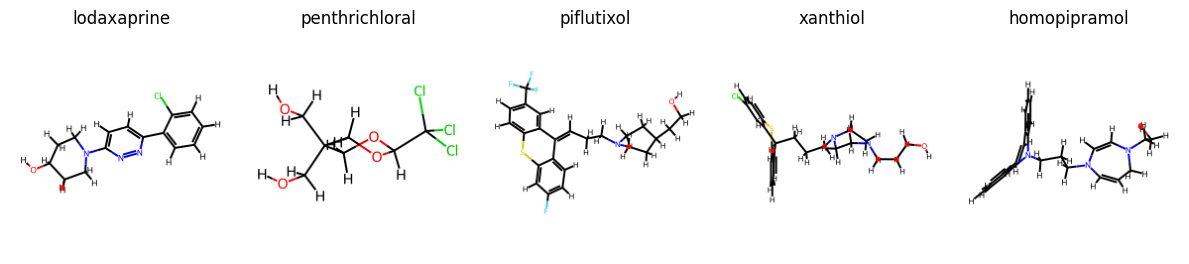

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(12, 6))

for i in range(5):
    axs[i].imshow(df_combined['image_array'][i+2500])  # Display the image
    axs[i].set_title(df_combined['compound_name'][i+2500])  # Set the title for each subplot
    axs[i].axis('off')  # Optionally turn off the axes for a cleaner look

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()


In [ ]:
df_combined.to_pickle('/content/drive/My Drive/descriptors_of_1_3dconformer_andoriginal_with_MACCS_&Images.pkl')

## Getting Embeddings from ChemBerta

In [ ]:
# Load pretrained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('seyonec/ChemBERTa_zinc250k_v2_40k')
model = AutoModel.from_pretrained('seyonec/ChemBERTa_zinc250k_v2_40k')

# Function to embed a single SMILES string
def embed_smiles(smiles):
    inputs = tokenizer(smiles, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    # You can take the mean of the embeddings or another summarization technique
    return embeddings.numpy()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/515 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/4.06k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

In [ ]:
# Apply embedding to each SMILES in the DataFrame
df_combined['SMILES_embedding'] = df_combined['SMILES'].apply(embed_smiles)

# Now your DataFrame contains the SMILES embeddings
print(df_combined[['SMILES', 'SMILES_embedding']])

                                                 SMILES                                   SMILES_embedding
0      O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O  [[[-1.3687841, -1.5950059, -0.21034011, 0.0730...
1     COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...  [[[-1.2403233, -1.1392882, -0.06400142, 0.9682...
2                                Oc1c(I)cc(Cl)c2cccnc12  [[[-0.087047674, -1.3248055, -0.38791606, 0.83...
3                            CCNC(=NCCSCc1ncccc1Br)NC#N  [[[0.32397547, -1.4202377, -0.15365471, 1.5906...
4     CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...  [[[-2.3543403, -1.0623921, 0.29315922, 0.77734...
...                                                 ...                                                ...
7573                    c1ccc(CN(CC2=NCCN2)c2ccccc2)cc1  [[[-1.1955574, -1.7856729, -0.34480298, 0.0771...
7574                   CCOCCn1c(N2CCCN(C)CC2)nc2ccccc21  [[[-0.021897469, -1.6326538, 0.1300816, 0.2674...
7575               CN1CCC(=C2c3ccccc3

## Getting Morgan FingerPrints

In [ ]:
df_combined = pd.read_pickle('/content/drive/My Drive/descriptors_of_1_3dconformer_COMPLETE.pkl')

In [ ]:
# Function to generate Morgan fingerprint as a bit vector
def generate_morgan_fingerprint(mol, radius=2, n_bits=2048):
    # Generate the fingerprint as a bit vector
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)

    # Convert the bit vector to a numpy array of 0s and 1s
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)

    return arr

# Apply the fingerprint generation to each molecule in the DataFrame
fingerprints = df_combined['Molecule'].apply(lambda mol: generate_morgan_fingerprint(mol, 3, 2048))

fingerprint_df = pd.DataFrame(
    fingerprints.tolist(),
    columns=[f'FP_{i}' for i in range(2048)]
)


df_combined = pd.concat([df_combined.reset_index(drop=True), fingerprint_df], axis=1)

In [ ]:
df_combined.to_pickle('/content/drive/My Drive/descriptors_of_1_3dconformer_COMPLETE.pkl')

# Setting Up for Modelling

In [ ]:
# Importing the Data
df_combined = pd.read_pickle('/content/drive/My Drive/descriptors_of_1_3dconformer_COMPLETE.pkl')
df_combined.shape

(7578, 4052)

In [ ]:
# Dropping Columns
df_combined = df_combined.drop(['SMILES','CID','IUPAC_name','Inchi','Mol_2d','Molecule','compound_name','NO.'],axis=1)
# Label Encoding the Target Variable
df_combined['BBB+/BBB-'] = df_combined['BBB+/BBB-'].map({'BBB+' :1,'BBB-':0})

In [ ]:
df_combined['BBB+/BBB-'].value_counts()

BBB+/BBB-
1    4854
0    2724
Name: count, dtype: int64

In [ ]:
# Print shape Before
print('Shape Before dropping the Columns ',df_combined.shape)
# Columns to Drop
cols_too_many_nans = df_combined.T.loc[df_combined.isna().sum() == len(df_combined)].index.to_list() # Drop Columns That are all NaNs
df_combined = df_combined.drop(cols_too_many_nans,axis=1)
print('Shape after Dropping the Columns',df_combined.shape)

Shape Before dropping the Columns  (7578, 4044)
Shape after Dropping the Columns (7578, 3792)


<b> Summing Across the Embeddings <i>-- Mean Pooling -- </i> </b>  

In [ ]:
def mean_pooling(embeddings):
    # Removing the batch dimension
    embeddings = np.squeeze(embeddings, axis=0)  # Shape: (seq, 768)
    # Computing the mean over the sequence dimension (tokens)
    mean_embedding = embeddings.mean(axis=0)  # Shape: (768,)
    return mean_embedding

# Applying the Function the Smiles Embedding Column
df_combined['SMILES_embedding'] = df_combined['SMILES_embedding'].apply(mean_pooling)
# Number of embedding dimensions
embedding_dim = 768

# Create a DataFrame from the embeddings
embedding_df = pd.DataFrame(df_combined['SMILES_embedding'].tolist(), columns=[f"embed_{i}" for i in range(embedding_dim)])

In [ ]:
# Concatenate the embeddings DataFrame with your original DataFrame
df_combined = pd.concat([df_combined.drop(columns=['SMILES_embedding']), embedding_df], axis=1)
df_combined.shape

(7578, 4559)

In [ ]:
# Dropping 'SMILES' and 'image_array' columns
df_temp = df_combined.drop(['image_array'], axis=1)
# Seperating Columns into Lists
morgan = [col for col in df_temp.columns if  'FP_'  in str(col) and 'MACCS' not in str(col)]
maccs = [col for col in df_temp.columns if 'MACCS' in str(col)]
embeds = [col for col in df_temp.columns if 'embed' in str(col)]
features = [col for col in df_temp.columns if   'FP_'  not in str(col) and
            'MACCS' not in str(col) and 'embed' not in str(col) and 'BBB+/BBB-' not in str(col)]
# df_temp.head()

In [ ]:
df_temp.shape

(7578, 4558)

In [ ]:
len(maccs)

167

In [ ]:
len(features)

1574

In [ ]:
# Separate features (X) and target (y)
X = df_temp.drop(['BBB+/BBB-'], axis=1)
y = df_temp['BBB+/BBB-']
print(X.shape)
print(y.shape)

(7578, 4557)
(7578,)


In [ ]:
X.head()

nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A     SpAD_A   SpMAD_A   LogEE_A     VE1_A     VE2_A     VE3_A        VR1_A      VR2_A     VR3_A  nAromAtom  nAromBond  nAtom  nHeavyAtom  nSpiro  nBridgehead  nHetero  nH  nB  nC  nN  nO  nS  nP  nF  nCl  nBr  nI  nX      ATS0dv      ATS1dv      ATS2dv       ATS3dv      ATS4dv       ATS5dv       ATS6dv       ATS7dv      ATS8dv  ATS0d  ATS1d  ATS2d  ATS3d  ATS4d  ATS5d  ATS6d  ATS7d  ATS8d       ATS0s       ATS1s       ATS2s       ATS3s       ATS4s       ATS5s       ATS6s       ATS7s       ATS8s   ATS0Z   ATS1Z   ATS2Z   ATS3Z   ATS4Z   ATS5Z   ATS6Z   ATS7Z   ATS8Z         ATS0m        ATS1m         ATS2m         ATS3m         ATS4m         ATS5m         ATS6m         ATS7m         ATS8m         ATS0v         ATS1v         ATS2v         ATS3v         ATS4v         ATS5v         ATS6v         ATS7v         ATS8v      ATS0se      ATS1se      ATS2se       ATS3se       ATS4se       ATS5se       ATS6se       ATS7se       ATS8se    ATS0pe    ATS1pe    ATS2pe     ATS3pe     ATS4pe     ATS5pe     ATS6pe    ATS7pe    ATS8pe   ATS0are   ATS1are   ATS2are    ATS3are    ATS4are    ATS5are    ATS6are   ATS7are   ATS8are      ATS0p       ATS1p       ATS2p       ATS3p       ATS4p       ATS5p       ATS6p       ATS7p       ATS8p        ATS0i        ATS1i         ATS2i         ATS3i         ATS4i         ATS5i         ATS6i         ATS7i         ATS8i    AATS0dv    AATS1dv   AATS2dv   AATS3dv   AATS4dv   AATS5dv   AATS6dv   AATS7dv   AATS8dv    AATS0d    AATS1d    AATS2d    AATS3d    AATS4d    AATS5d    AATS6d    AATS7d    AATS8d    AATS0s    AATS1s    AATS2s    AATS3s    AATS4s    AATS5s    AATS6s    AATS7s    AATS8s      AATS0Z     AATS1Z     AATS2Z     AATS3Z     AATS4Z     AATS5Z     AATS6Z     AATS7Z     AATS8Z       AATS0m      AATS1m      AATS2m      AATS3m      AATS4m      AATS5m      AATS6m     AATS7m     AATS8m      AATS0v      AATS1v      AATS2v      AATS3v      AATS4v      AATS5v      AATS6v      AATS7v      AATS8v   AATS0se   AATS1se   AATS2se   AATS3se   AATS4se   AATS5se   AATS6se   AATS7se   AATS8se   AATS0pe   AATS1pe   AATS2pe   AATS3pe   AATS4pe   AATS5pe   AATS6pe   AATS7pe   AATS8pe  AATS0are  AATS1are  AATS2are  AATS3are  AATS4are  AATS5are  AATS6are  AATS7are  AATS8are    AATS0p    AATS1p    AATS2p    AATS3p    AATS4p    AATS5p    AATS6p    AATS7p    AATS8p      AATS0i      AATS1i      AATS2i      AATS3i      AATS4i      AATS5i      AATS6i      AATS7i      AATS8i    ATSC0c    ATSC1c    ATSC2c    ATSC3c    ATSC4c    ATSC5c    ATSC6c    ATSC7c    ATSC8c     ATSC0dv    ATSC1dv    ATSC2dv    ATSC3dv    ATSC4dv     ATSC5dv    ATSC6dv    ATSC7dv     ATSC8dv     ATSC0d     ATSC1d    ATSC2d     ATSC3d     ATSC4d    ATSC5d    ATSC6d     ATSC7d    ATSC8d      ATSC0s     ATSC1s     ATSC2s     ATSC3s     ATSC4s     ATSC5s     ATSC6s     ATSC7s     ATSC8s       ATSC0Z     ATSC1Z     ATSC2Z      ATSC3Z      ATSC4Z      ATSC5Z      ATSC6Z      ATSC7Z      ATSC8Z        ATSC0m      ATSC1m      ATSC2m       ATSC3m      ATSC4m      ATSC5m       ATSC6m       ATSC7m       ATSC8m       ATSC0v      ATSC1v      ATSC2v      ATSC3v      ATSC4v      ATSC5v      ATSC6v      ATSC7v      ATSC8v   ATSC0se   ATSC1se   ATSC2se   ATSC3se   ATSC4se   ATSC5se   ATSC6se   ATSC7se   ATSC8se    ATSC0pe   ATSC1pe   ATSC2pe   ATSC3pe   ATSC4pe   ATSC5pe   ATSC6pe   ATSC7pe   ATSC8pe   ATSC0are  ATSC1are  ATSC2are  ATSC3are  ATSC4are  ATSC5are  ATSC6are  ATSC7are  ATSC8are     ATSC0p    ATSC1p    ATSC2p    ATSC3p    ATSC4p    ATSC5p    ATSC6p    ATSC7p    ATSC8p     ATSC0i     ATSC1i     ATSC2i     ATSC3i     ATSC4i     ATSC5i     ATSC6i     ATSC7i     ATSC8i   AATSC0c   AATSC1c   AATSC2c   AATSC3c   AATSC4c   AATSC5c   AATSC6c   AATSC7c   AATSC8c  AATSC0dv  AATSC1dv  AATSC2dv  AATSC3dv  AATSC4dv  AATSC5dv  AATSC6dv  AATSC7dv  AATSC8dv   AATSC0d   AATSC1d   AATSC2d   AATSC3d   AATSC4d   AATSC5d   AATSC6d   AATSC7d   AATSC8d   AATSC0s   AATSC1s   AATSC2s   AATSC3s   AATSC4s   AATSC5s   AATSC6s   AATSC7s   AATSC8s     AAT

# Modelling





## Just Features & Fingerprints

In [ ]:
X = X.drop(embeds,axis = 1)
print('Number of Embeddings Columns' ,len(embeds))
print('Dimensions of X after Dropping the Embeddings',X.shape)

Number of Embeddings Columns 1
Dimensions of X after Dropping the Embeddings (7578, 3789)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 1024 , stratify = y, random_state = 404 )
print(y_test.value_counts())
print(len(X_train))
print(y_train.value_counts())

BBB+/BBB-
1    656
0    368
Name: count, dtype: int64
6554
BBB+/BBB-
1    4198
0    2356
Name: count, dtype: int64


### XGBoost
* Images Dropped
* No Embeddings
* MACCS & Morgan FP
* 3D Descriptors
* All NaN Columns Dropped
* Didn't deal with NaNs Left them for the algorithm

In [ ]:
# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_train
    )

print (class_weights[0])
print (class_weights[1])
print(classes)

1.3909168081494059
0.7806098141972367
[0 1]


In [ ]:
# Define the parameter grid
param_grid = {
            'n_estimators': [230,240],
            'max_depth': [8,9],
            'learning_rate': [0.1],
            'subsample': [0.8,0.9 ],
        }

# Initialize the XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric= f1_score, sample_weights = class_weights)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=4)

# Fit the model using grid search
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)


Fitting 10 folds for each of 8 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:33:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sample_weights", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 240, 'subsample': 0.8}


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       368
           1       0.90      0.95      0.92       656

    accuracy                           0.90      1024
   macro avg       0.90      0.88      0.89      1024
weighted avg       0.90      0.90      0.90      1024





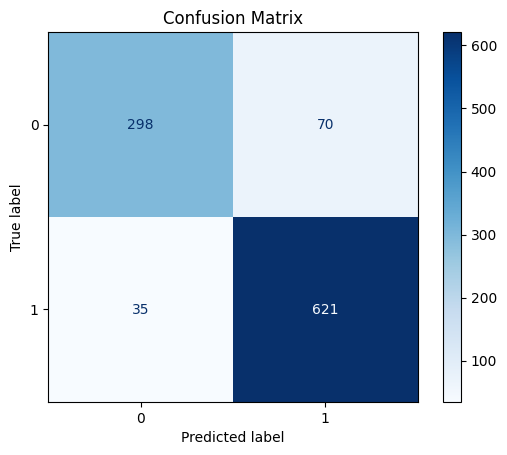

Sensitivity (Recall): 0.9466
Specificity: 0.8098
Precision: 0.8987
Recall: 0.9466
F1 Score: 0.9220
AUROC: 0.9637


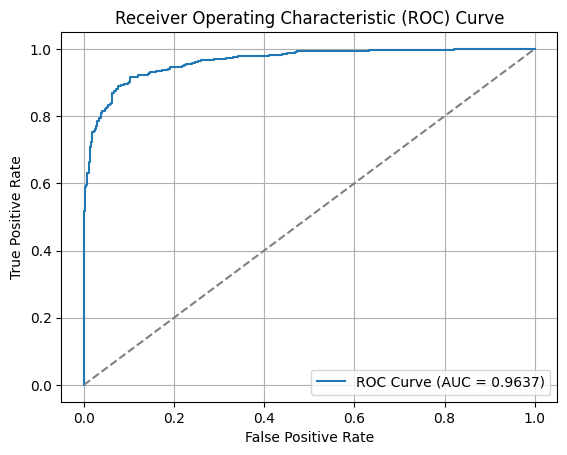

AUPRC: 0.9804


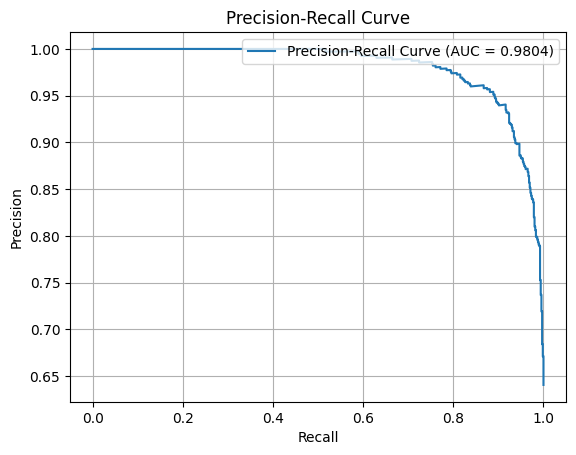

In [ ]:
# Predict using the best estimator from grid search
best_xgb = grid_search.best_estimator_

report_model(best_xgb, X_test,y_test)

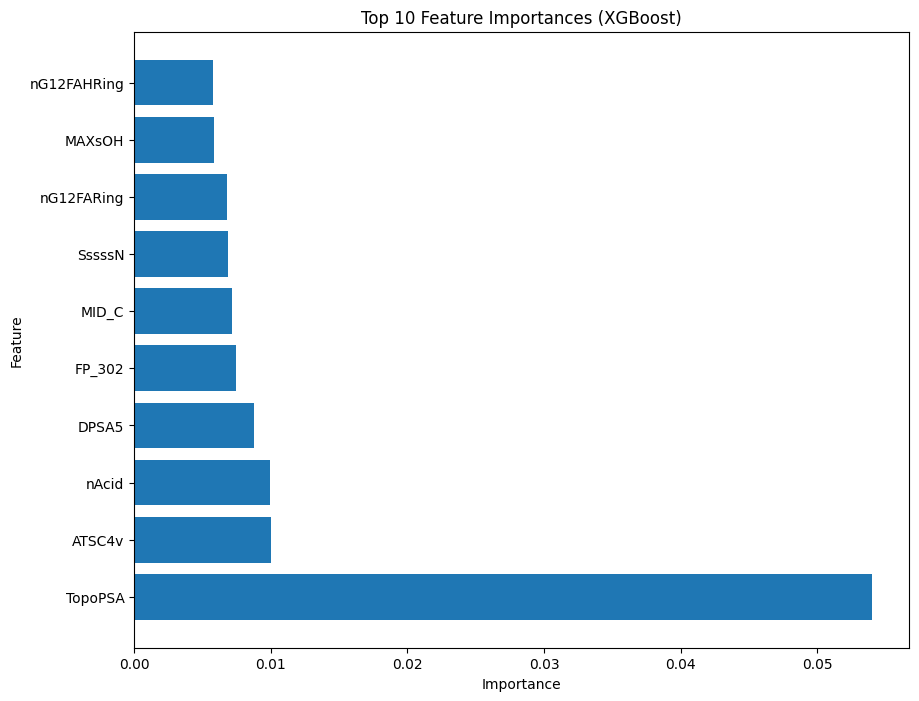

In [ ]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Select only the top 10 features
top_10_features = feature_importance_df.head(10)

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()


### LightGBM

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [240,250],
    'max_depth': [8],
    'learning_rate': [0.15,0.1],
    'subsample': [0.8,0.9],
    'reg_lambda' : [0.1,0],
}

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(class_weight='balanced' )

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=4)

# Fit the model using grid search
grid_search.fit(X_train, y_train)
# Print the Best Parameters Found
print("Best parameters for Random Forest:", grid_search.best_params_)
#Best parameters for Random Forest: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 240, 'reg_lambda': 0.1, 'subsample': 0.8}

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       368
           1       0.90      0.93      0.92       656

    accuracy                           0.89      1024
   macro avg       0.89      0.88      0.88      1024
weighted avg       0.89      0.89      0.89      1024





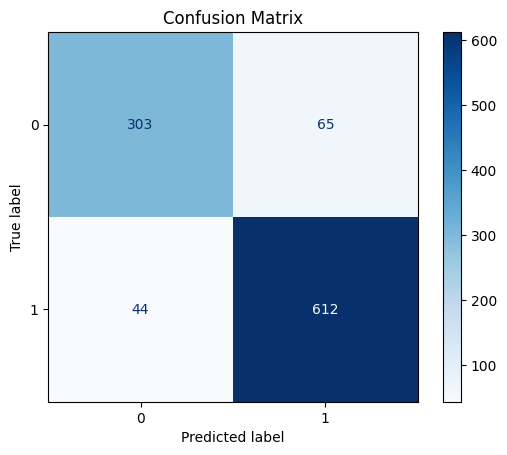

Sensitivity (Recall): 0.9329
Specificity: 0.8234
Precision: 0.9040
Recall: 0.9329
F1 Score: 0.9182
AUROC: 0.9610


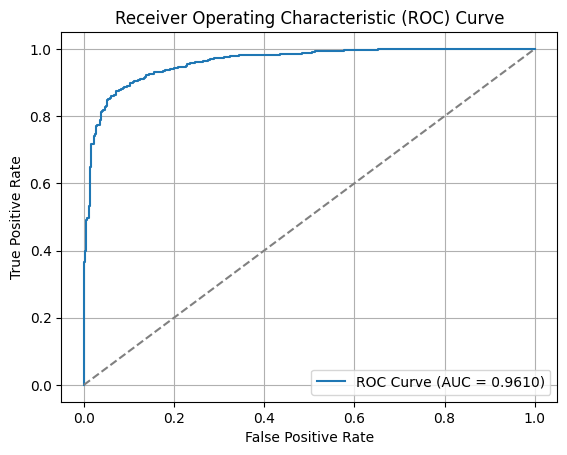

AUPRC: 0.9778


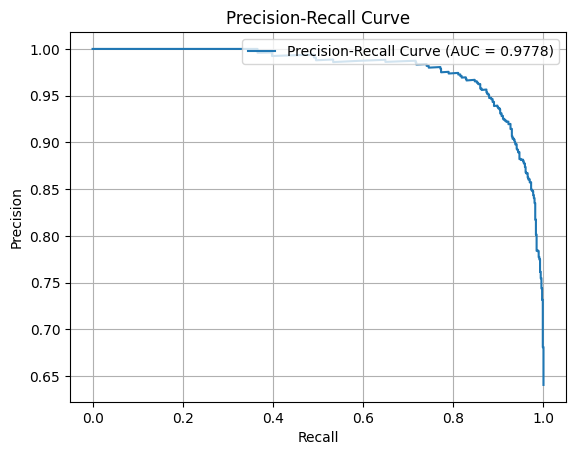

In [ ]:
# Predict using the best estimator from grid search
best_lgbm = grid_search.best_estimator_
report_model(best_lgbm, X_test,y_test)

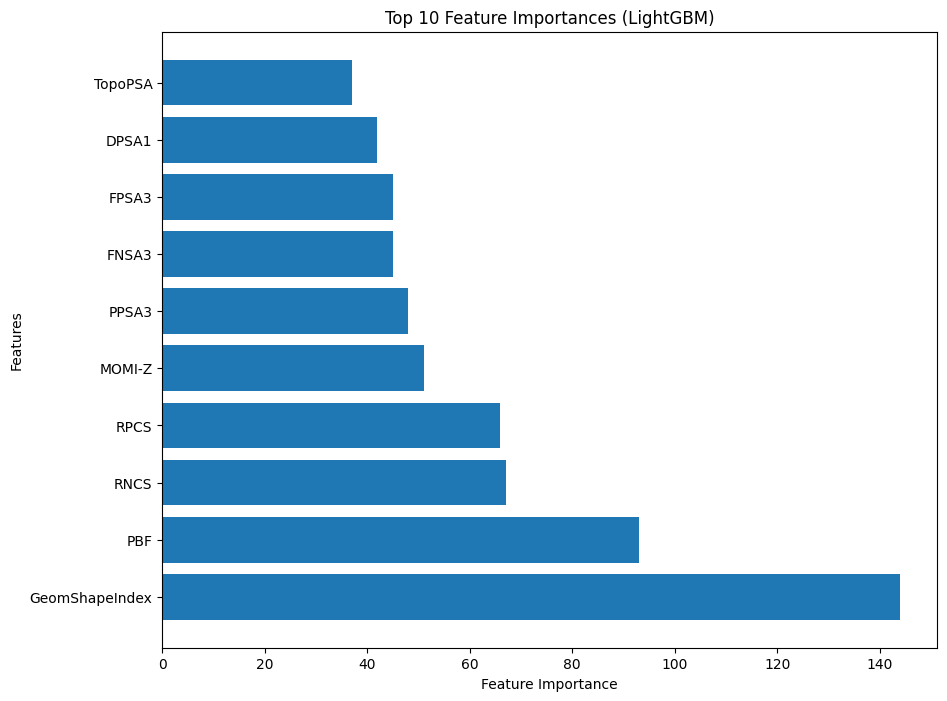

In [ ]:
# Assuming 'best_lgbm' is your trained LightGBM model
feature_importance = best_lgbm.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Select only the top 10 features
top_10_features = feature_importance_df.head(10)

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances (LightGBM)')
plt.show()


## Just Embeds

In [ ]:
X = df_temp[embeds]
print('Number of Embeddings Columns' ,len(embeds))
print('Dimensions of X after Dropping the Features ',X.shape)

Number of Embeddings Columns 768
Dimensions of X after Dropping the Features  (7578, 768)


In [ ]:
X.head()

embed_0   embed_1   embed_2   embed_3   embed_4   embed_5   embed_6   embed_7   embed_8   embed_9  embed_10  embed_11  embed_12  embed_13  embed_14  embed_15  embed_16  embed_17  embed_18  embed_19  embed_20  embed_21  embed_22  embed_23  embed_24  embed_25  embed_26  embed_27  embed_28  embed_29  embed_30  embed_31  embed_32  embed_33  embed_34  embed_35  embed_36  embed_37  embed_38  embed_39  embed_40  embed_41  embed_42  embed_43  embed_44  embed_45  embed_46  embed_47  embed_48  embed_49  embed_50  embed_51  embed_52  embed_53  embed_54  embed_55  embed_56  embed_57  embed_58  embed_59  embed_60  embed_61  embed_62  embed_63  embed_64  embed_65  embed_66  embed_67  embed_68  embed_69  embed_70  embed_71  embed_72  embed_73  embed_74  embed_75  embed_76  embed_77  embed_78  embed_79  embed_80  embed_81  embed_82  embed_83  embed_84  embed_85  embed_86  embed_87  embed_88  embed_89  embed_90  embed_91  embed_92  embed_93  embed_94  embed_95  embed_96  embed_97  embed_98  embed_99  embed_100  embed_101  embed_102  embed_103  embed_104  embed_105  embed_106  embed_107  embed_108  embed_109  embed_110  embed_111  embed_112  embed_113  embed_114  embed_115  embed_116  embed_117  embed_118  embed_119  embed_120  embed_121  embed_122  embed_123  embed_124  embed_125  embed_126  embed_127  embed_128  embed_129  embed_130  embed_131  embed_132  embed_133  embed_134  embed_135  embed_136  embed_137  embed_138  embed_139  embed_140  embed_141  embed_142  embed_143  embed_144  embed_145  embed_146  embed_147  embed_148  embed_149  embed_150  embed_151  embed_152  embed_153  embed_154  embed_155  embed_156  embed_157  embed_158  embed_159  embed_160  embed_161  embed_162  embed_163  embed_164  embed_165  embed_166  embed_167  embed_168  embed_169  embed_170  embed_171  embed_172  embed_173  embed_174  embed_175  embed_176  embed_177  embed_178  embed_179  embed_180  embed_181  embed_182  embed_183  embed_184  embed_185  embed_186  embed_187  embed_188  embed_189  embed_190  embed_191  embed_192  embed_193  embed_194  embed_195  embed_196  embed_197  embed_198  embed_199  embed_200  embed_201  embed_202  embed_203  embed_204  embed_205  embed_206  embed_207  embed_208  embed_209  embed_210  embed_211  embed_212  embed_213  embed_214  embed_215  embed_216  embed_217  embed_218  embed_219  embed_220  embed_221  embed_222  embed_223  embed_224  embed_225  embed_226  embed_227  embed_228  embed_229  embed_230  embed_231  embed_232  embed_233  embed_234  embed_235  embed_236  embed_237  embed_238  embed_239  embed_240  embed_241  embed_242  embed_243  embed_244  embed_245  embed_246  embed_247  embed_248  embed_249  embed_250  embed_251  embed_252  embed_253  embed_254  embed_255  embed_256  embed_257  embed_258  embed_259  embed_260  embed_261  embed_262  embed_263  embed_264  embed_265  embed_266  embed_267  embed_268  embed_269  embed_270  embed_271  embed_272  embed_273  embed_274  embed_275  embed_276  embed_277  embed_278  embed_279  embed_280  embed_281  embed_282  embed_283  embed_284  embed_285  embed_286  embed_287  embed_288  embed_289  embed_290  embed_291  embed_292  embed_293  embed_294  embed_295  embed_296  embed_297  embed_298  embed_299  embed_300  embed_301  embed_302  embed_303  embed_304  embed_305  embed_306  embed_307  embed_308  embed_309  embed_310  embed_311  embed_312  embed_313  embed_314  embed_315  embed_316  embed_317  embed_318  embed_319  embed_320  embed_321  embed_322  embed_323  embed_324  embed_325  embed_326  embed_327  embed_328  embed_329  embed_330  embed_331  embed_332  embed_333  embed_334  embed_335  embed_336  embed_337  embed_338  embed_339  embed_340  embed_341  embed_342  embed_343  embed_344  embed_345  embed_346  embed_347  embed_348  embed_349  embed_350  embed_351  embed_352  embed_353  embed_354  embed_355  embed_356  embed_357  embed_358  embed_359  embed_360  embed_361  embed_362  embed_363  embed_364  embed_365  embed_366  embed_367  embed_368  embed_369  embed_370  embed_371  embed_372

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 1024 , stratify = y, random_state = 404 )

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_test.value_counts()

BBB+/BBB-
1    656
0    368
Name: count, dtype: int64

### XGBoost

In [ ]:
# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_train
    )

print (class_weights[0])
print (class_weights[1])
print(classes)

1.3909168081494059
0.7806098141972367
[0 1]


In [ ]:
# Define the parameter grid
param_grid = {
            'n_estimators': [230,240],
            'max_depth': [8,9],
            'learning_rate': [0.1],
            'subsample': [0.8,0.9],
        }

# Initialize the XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric= f1_score, sample_weights = class_weights)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=4)

# Fit the model using grid search
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)


Fitting 10 folds for each of 8 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:59:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sample_weights", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 240, 'subsample': 0.8}


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       368
           1       0.88      0.92      0.90       656

    accuracy                           0.87      1024
   macro avg       0.86      0.85      0.85      1024
weighted avg       0.87      0.87      0.87      1024





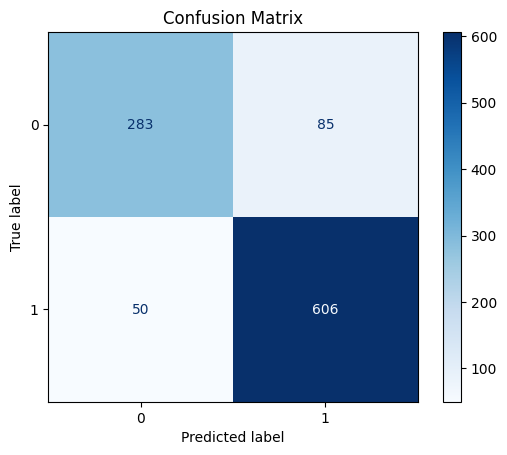

Sensitivity (Recall): 0.9238
Specificity: 0.7690
Precision: 0.8770
Recall: 0.9238
F1 Score: 0.8998
AUROC: 0.9485


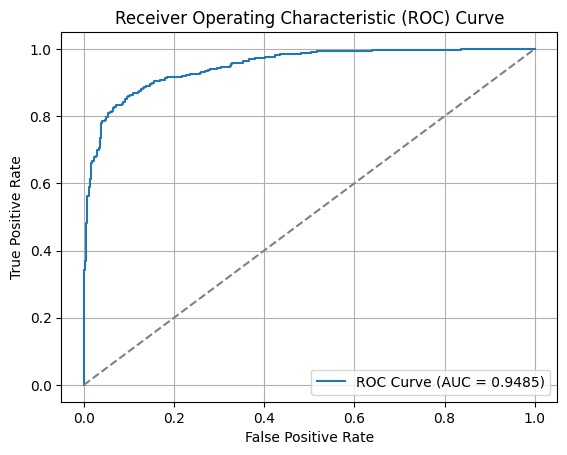

AUPRC: 0.9713


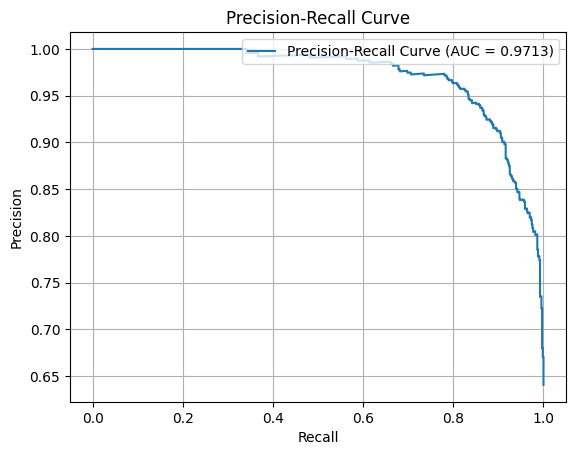

In [ ]:
# Predict using the best estimator from grid search
best_xgb = grid_search.best_estimator_

report_model(best_xgb, X_test,y_test)

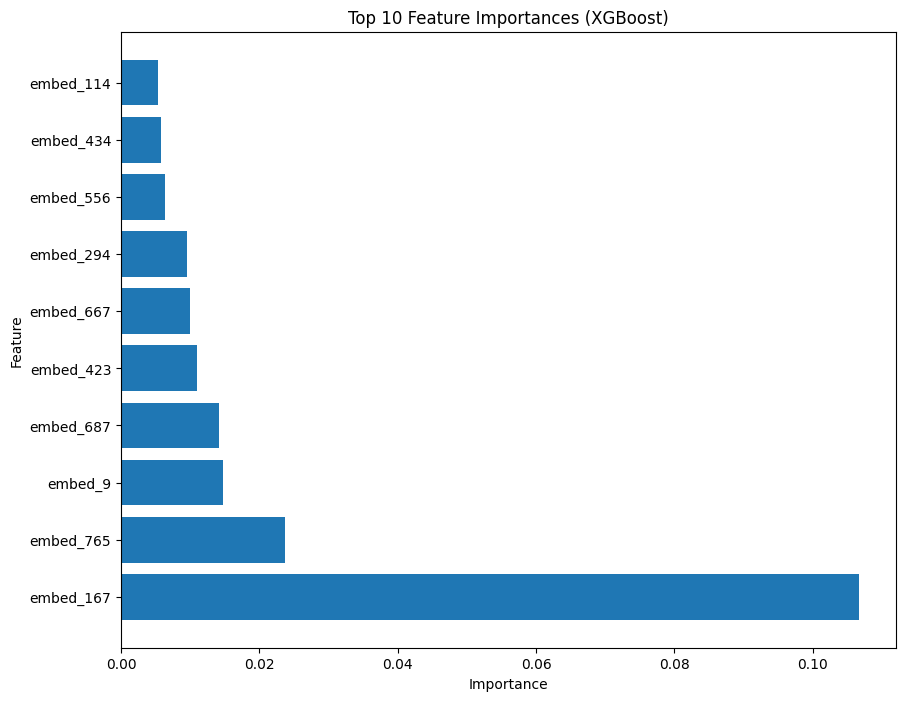

In [ ]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Select only the top 10 features
top_10_features = feature_importance_df.head(10)

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()


### LightGBM

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [240,250],
    'max_depth': [8],
    'learning_rate': [0.15,0.1],
    'subsample': [0.8,0.9],
    'reg_lambda' : [0.1,0],
}

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(class_weight='balanced' )

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=4)

# Fit the model using grid search
grid_search.fit(X_train, y_train)
# Print the Best Parameters Found
print("Best parameters for LGBM:", grid_search.best_params_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[LightGBM] [Info] Number of positive: 4198, number of negative: 2356
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 6554, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for LGBM: {'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 240, 'reg_lambda': 0, 'subsample': 0.8}


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       368
           1       0.90      0.92      0.91       656

    accuracy                           0.88      1024
   macro avg       0.87      0.86      0.87      1024
weighted avg       0.88      0.88      0.88      1024





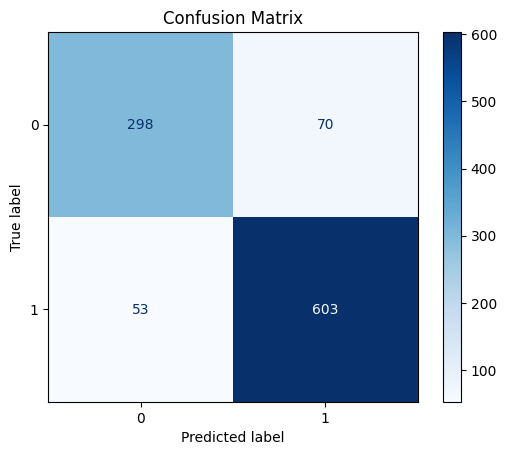

Sensitivity (Recall): 0.9192
Specificity: 0.8098
Precision: 0.8960
Recall: 0.9192
F1 Score: 0.9074
AUROC: 0.9471


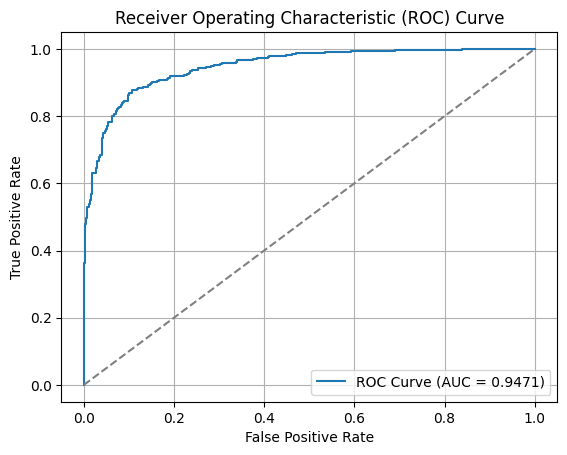

AUPRC: 0.9702


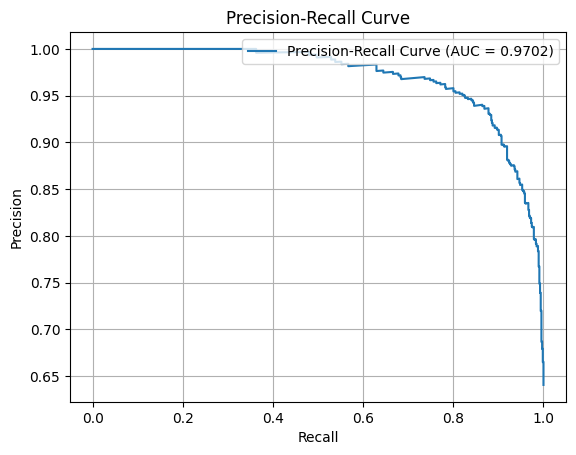

In [ ]:
# Predict using the best estimator from grid search
best_lgbm = grid_search.best_estimator_
report_model(best_lgbm, X_test,y_test)

In [ ]:
# Assuming 'best_lgbm' is your trained LightGBM model
feature_importance = best_lgbm.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Select only the top 10 features
top_10_features = feature_importance_df.head(10)

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances (LightGBM)')
plt.show()


## Embeds & FingerPrints

In [ ]:
X = df_temp.drop(['BBB+/BBB-'], axis=1)
X = X.drop(features, axis=1)
y = df_temp['BBB+/BBB-']
print('Shape of df_temp' , df_temp.shape)
print('Shape of X after dropping the Feature Columns',X.shape)
print(len(features))

Shape of df_temp (7578, 4558)
Shape of X after dropping the Feature Columns (7578, 2983)
1574


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 1024 , stratify = y, random_state = 404 )

# scaler = StandardScaler()
# X_train[embeds] = scaler.fit_transform(X_train[embeds])
# X_test[embeds] = scaler.transform(X_test[embeds])

# import joblib
# # Save the scaler to a file
# joblib.dump(scaler, '/content/drive/My Drive/scaler_model.pkl')

print(y_test.value_counts())
print(y_train.value_counts())

BBB+/BBB-
1    656
0    368
Name: count, dtype: int64
BBB+/BBB-
1    4198
0    2356
Name: count, dtype: int64


### XGBoost

In [ ]:
# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_train
    )

print (class_weights[0])
print (class_weights[1])
print(classes)

1.3908839779005524
0.7806201550387597
[0 1]


In [ ]:
# Define the parameter grid
param_grid = {
            'n_estimators': [230,240],
            'max_depth': [8,9],
            'learning_rate': [0.1],
            'subsample': [0.8,0.9],
        }

# Initialize the XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric= f1_score, sample_weights = class_weights)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=4)

# Fit the model using grid search
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)


Fitting 10 folds for each of 8 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:27:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sample_weights", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 230, 'subsample': 0.8}


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       368
           1       0.89      0.94      0.91       656

    accuracy                           0.89      1024
   macro avg       0.88      0.87      0.88      1024
weighted avg       0.89      0.89      0.89      1024





Sensitivity (Recall): 0.9360
Specificity: 0.8016
Precision: 0.8937
Recall: 0.9360
F1 Score: 0.9144
AUROC: 0.9535


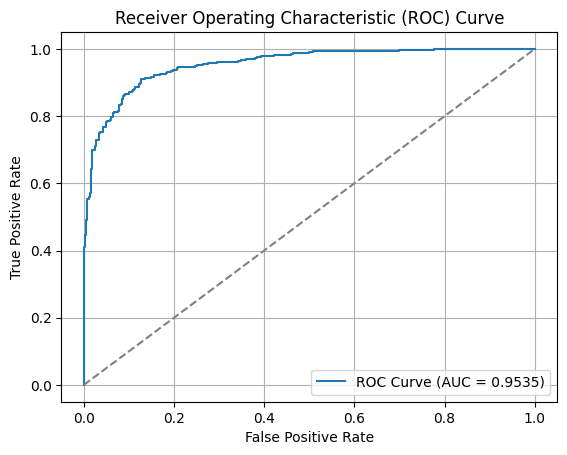

AUPRC: 0.9740


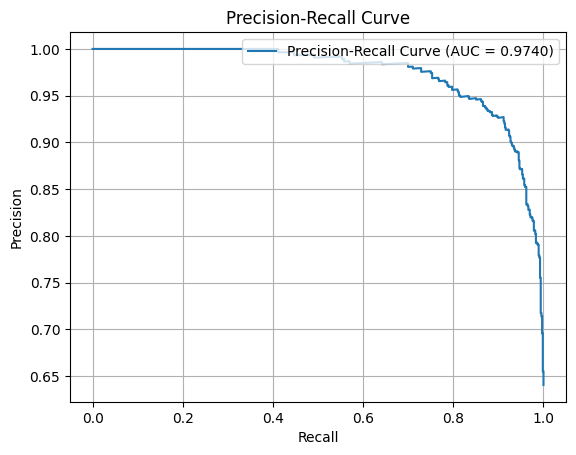

In [ ]:
# Predict using the best estimator from grid search
best_xgb = grid_search.best_estimator_

report_model(best_xgb, X_test,y_test)

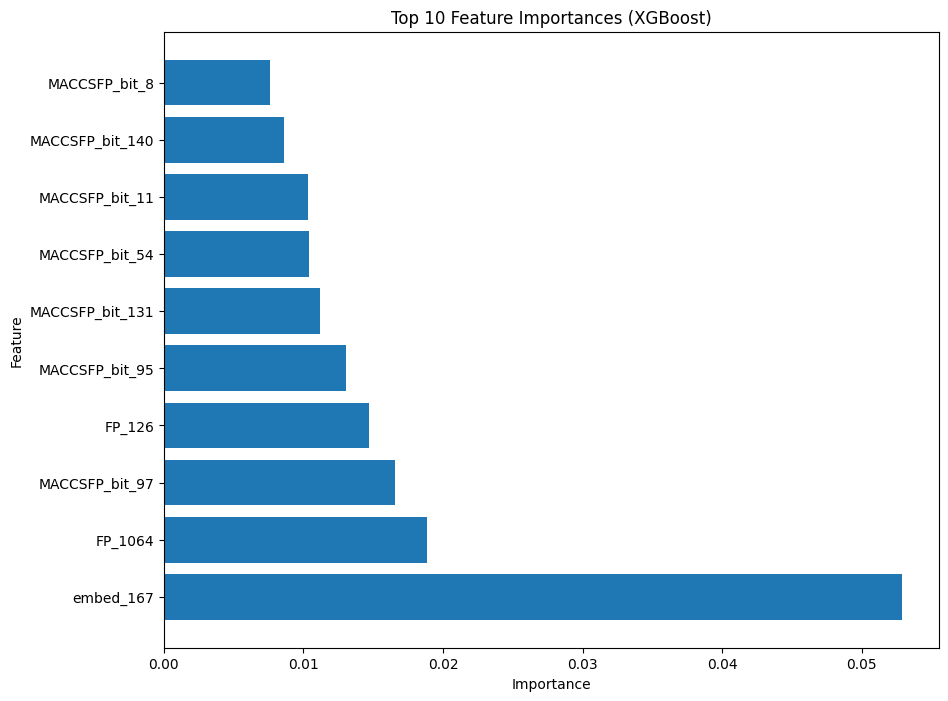

In [ ]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Select only the top 10 features
top_10_features = feature_importance_df.head(10)

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()

### LightGBM

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [240,250],
    'max_depth': [8],
    'learning_rate': [0.15,0.1],
    'subsample': [0.8,0.9],
    'reg_lambda' : [0.1,0],
}

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(class_weight='balanced' )

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=4)

# Fit the model using grid search
grid_search.fit(X_train, y_train)
# Print the Best Parameters Found
print("Best parameters for LGBM:", grid_search.best_params_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       368
           1       0.90      0.93      0.91       656

    accuracy                           0.89      1024
   macro avg       0.88      0.87      0.87      1024
weighted avg       0.89      0.89      0.89      1024





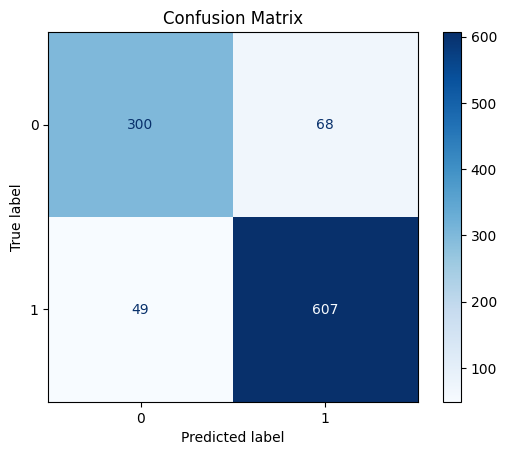

Sensitivity (Recall): 0.9253
Specificity: 0.8152
Precision: 0.8993
Recall: 0.9253
F1 Score: 0.9121
AUROC: 0.9525


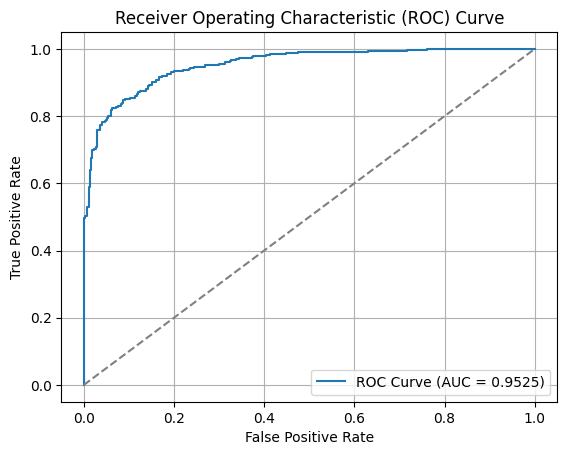

AUPRC: 0.9740


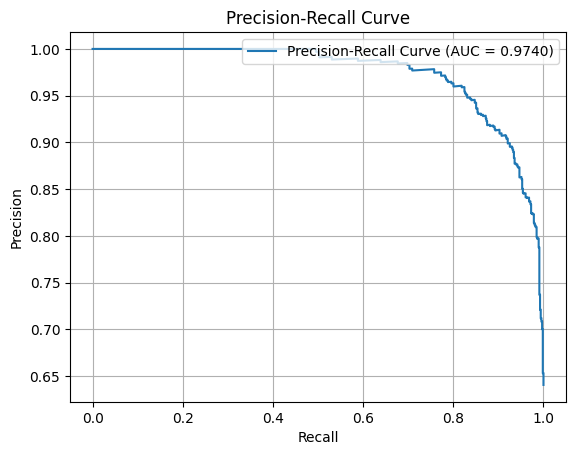

In [ ]:
# Predict using the best estimator from grid search
best_lgbm = grid_search.best_estimator_
report_model(best_lgbm, X_test,y_test)

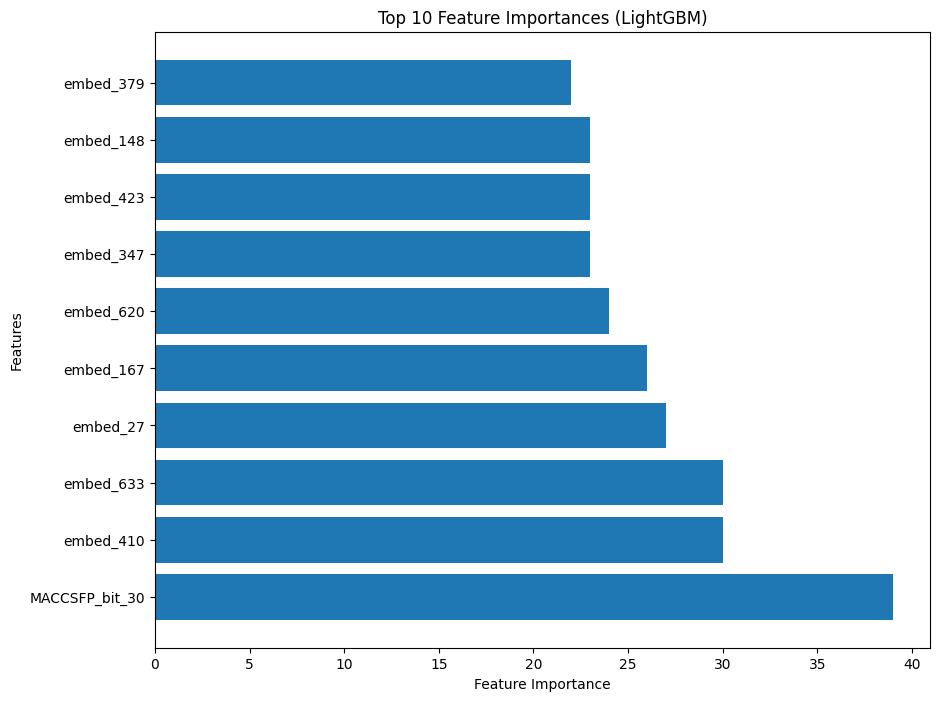

In [ ]:
# Assuming 'best_lgbm' is your trained LightGBM model
feature_importance = best_lgbm.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Select only the top 10 features
top_10_features = feature_importance_df.head(10)

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances (LightGBM)')
plt.show()


### Neural Nets

In [ ]:
# Splitting into Validation Set and Training Set for Neural Nets
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train , test_size = 512 , stratify = y_train ,random_state = 303 )
print(y_val.value_counts())
print(len(X_train))
print(y_train.value_counts())

BBB+/BBB-
1    328
0    184
Name: count, dtype: int64
6042
BBB+/BBB-
1    3870
0    2172
Name: count, dtype: int64


#### DataLoader



In [ ]:
def create_loader(X_train=X_train, y_train = y_train,
                  X_val=X_val , y_val = y_val,
                  X_holdout = X_test , y_holdout=y_test,
                  batchsize = 32 ) :
  X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
  X_holdout_tensor= torch.tensor(X_holdout.values, dtype=torch.float32)
  y_holdout_tensor=torch.tensor(y_holdout.values, dtype=torch.float32)
  X_val_tensor=torch.tensor(X_val.values, dtype=torch.float32)
  y_val_tensor=torch.tensor(y_val.values, dtype=torch.float32)

  batch_size = batchsize  # Adjustable as needed

  # Create datasets
  train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
  val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
  holdout_dataset = TensorDataset(X_holdout_tensor, y_holdout_tensor)

  # Create dataloaders
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True  )
  val_loader = DataLoader(val_dataset, batch_size=val_dataset.tensors[1].size()[0])
  holdout_loader = DataLoader(holdout_dataset, batch_size=holdout_dataset.tensors[1].size()[0])

  return train_loader,val_loader,holdout_loader

#### FFN

In [ ]:
class FFN(nn.Module):
    def __init__(self, input_dim, hidden_dim, multi_factor ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.multi_factor = multi_factor

        # First set of layers
        self.layer1 = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim * 2 * self.multi_factor),
            nn.BatchNorm1d(self.hidden_dim * 2 *self.multi_factor),
            nn.ReLU(),
            nn.Dropout(0.6),
        )

        # Output layers
        self.layer2 = nn.Sequential(
            nn.Linear(self.hidden_dim * 2 * self.multi_factor , self.hidden_dim * self.multi_factor),
            nn.BatchNorm1d(self.hidden_dim * self.multi_factor),
            nn.ReLU(),
            nn.Linear(self.hidden_dim * self.multi_factor, 1)
        )

    def forward(self, x):

        # First set of layers
        x = self.layer1(x)

        # Output layers
        out = self.layer2(x)

        return out


In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, early_stopping_patience=6 , trigger_early_stop = True ):
  # Init Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

    best_val_loss = np.Inf
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        all_preds = []
        all_labels = []
        all_outputs = []

        for X_batch, y_batch in train_loader:

            optimizer.zero_grad()

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # Forward Pass
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            epoch_losses.append(loss.item())

            # Back Propagarion
            loss.backward()
            optimizer.step()

            preds = (outputs.detach().cpu().numpy() > 0).astype(int)
            labels = y_batch.detach().cpu().numpy().astype(int)
            all_preds.extend(preds)
            all_labels.extend(labels)
            all_outputs.extend(outputs.detach().cpu().numpy())

        epoch_loss = np.mean(epoch_losses)
        epoch_f1 = f1_score(all_labels, all_preds)
        try:
            epoch_auc = roc_auc_score(all_labels, all_outputs)
        except ValueError:
            epoch_auc = 0

        # Validation Phase
        model.eval()
        validation_losses = []
        val_preds = []
        val_labels = []
        val_outputs = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                outputs = model(X_batch).squeeze()
                val_loss = criterion(outputs, y_batch)
                validation_losses.append(val_loss.item())

                preds = (outputs.detach().cpu().numpy() > 0).astype(int)
                labels = y_batch.detach().cpu().numpy().astype(int)
                val_preds.extend(preds)
                val_labels.extend(labels)
                val_outputs.extend(outputs.detach().cpu().numpy())

        validation_loss = np.mean(validation_losses)
        val_f1 = f1_score(val_labels, val_preds)
        try:
            val_auc = roc_auc_score(val_labels, val_outputs)
        except ValueError:
            val_auc = 0

        # Step the scheduler
        scheduler.step(validation_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, Train F1: {epoch_f1:.4f}, Train AUC: {epoch_auc:.4f} | "
              f"Val Loss: {validation_loss:.4f}, Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")

        # Early Stopping Check
        if trigger_early_stop == True :
          if validation_loss < best_val_loss:
              best_val_loss = validation_loss
              epochs_no_improve = 0
              # Save the best model state
              best_model_state = model.state_dict()
          else:
              epochs_no_improve += 1
              print(f"EarlyStopping counter: {epochs_no_improve} out of {early_stopping_patience}")
              if epochs_no_improve >= early_stopping_patience:
                  print('Early stopping triggered!')
                  # Load the best model state before stopping
                  if best_model_state is not None:
                      model.load_state_dict(best_model_state)
                  break
        else :
          pass
    # Optionally, return the best model
    return model


In [ ]:
# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_train
    )

# pos_weight is number of negative samples / number of positive samples

pos_weight_value = class_weights[0] / class_weights[1]

pos_weight = torch.tensor([pos_weight_value], dtype=torch.float).to(device)
print (class_weights[0])
print (class_weights[1])
print(classes)

1.3908839779005524
0.7806201550387597
[0 1]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader , val_loader , holdout_loader = create_loader(X_train=X_train, y_train = y_train,
                                                           X_val=X_val , y_val = y_val,
                                                           X_holdout = X_test , y_holdout=y_test,
                                                           batchsize = 16 )
learning_rate = 0.00005
hidden_dim = 128
multi_factor = 1
model = FFN(X_train.shape[1], hidden_dim , multi_factor).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 3e-5)
model

FFN(
  (layer1): Sequential(
    (0): Linear(in_features=2983, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
best_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs = 30 ,device=device ,)

Epoch [1/30], Train Loss: 0.5004, Train F1: 0.8281, Train AUC: 0.8354 | Val Loss: 0.4185, Val F1: 0.8752, Val AUC: 0.8975
Epoch [2/30], Train Loss: 0.3983, Train F1: 0.8725, Train AUC: 0.8930 | Val Loss: 0.3892, Val F1: 0.8655, Val AUC: 0.9110
Epoch [3/30], Train Loss: 0.3564, Train F1: 0.8868, Train AUC: 0.9175 | Val Loss: 0.3516, Val F1: 0.8853, Val AUC: 0.9210
Epoch [4/30], Train Loss: 0.3277, Train F1: 0.8990, Train AUC: 0.9306 | Val Loss: 0.3459, Val F1: 0.8879, Val AUC: 0.9283
Epoch [5/30], Train Loss: 0.3043, Train F1: 0.9039, Train AUC: 0.9402 | Val Loss: 0.3336, Val F1: 0.8936, Val AUC: 0.9288
Epoch [6/30], Train Loss: 0.2881, Train F1: 0.9083, Train AUC: 0.9471 | Val Loss: 0.3205, Val F1: 0.8942, Val AUC: 0.9332
Epoch [7/30], Train Loss: 0.2723, Train F1: 0.9126, Train AUC: 0.9531 | Val Loss: 0.3270, Val F1: 0.8875, Val AUC: 0.9336
EarlyStopping counter: 1 out of 6
Epoch [8/30], Train Loss: 0.2611, Train F1: 0.9177, Train AUC: 0.9563 | Val Loss: 0.3080, Val F1: 0.8966, Val AU

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       184
         1.0       0.90      0.89      0.90       328

    accuracy                           0.87       512
   macro avg       0.85      0.86      0.86       512
weighted avg       0.87      0.87      0.87       512

F1 Score: 0.8957


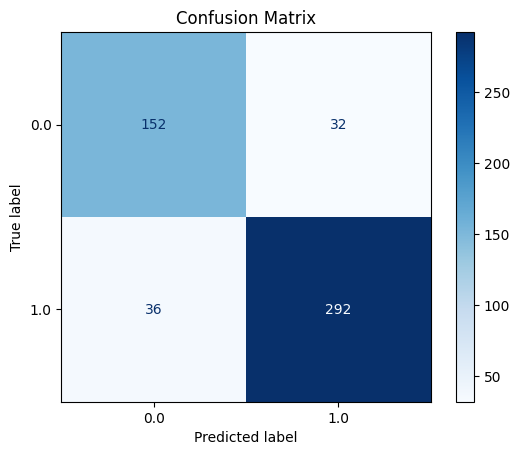

Sensitivity (Recall): 0.8902
Specificity: 0.8261
Precision: 0.9012
Recall: 0.8902
 
Matthews Correlation Coefficient (MCC): 0.7130
 


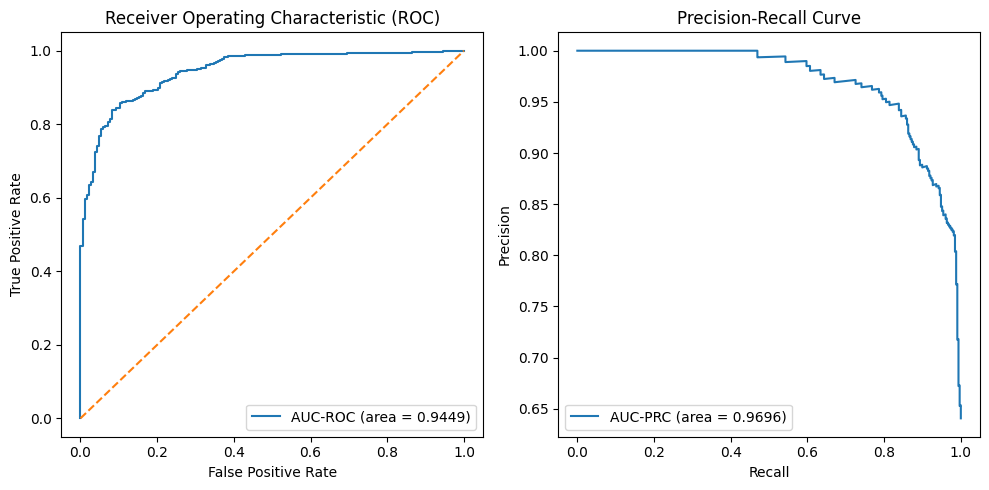

In [ ]:
evaluate_model(best_model,val_loader)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       368
         1.0       0.94      0.89      0.91       656

    accuracy                           0.89      1024
   macro avg       0.88      0.89      0.88      1024
weighted avg       0.89      0.89      0.89      1024

F1 Score: 0.9115


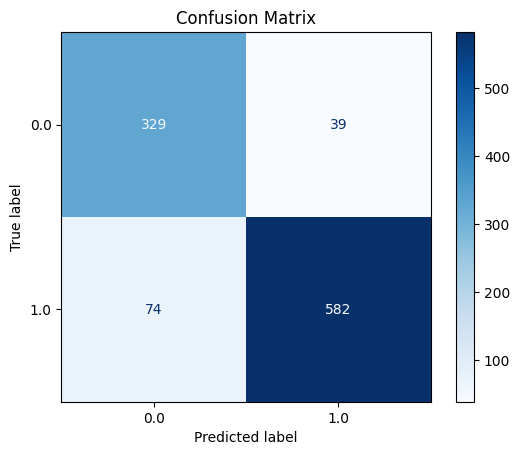

Sensitivity (Recall): 0.8872
Specificity: 0.8940
Precision: 0.9372
Recall: 0.8872
 
Matthews Correlation Coefficient (MCC): 0.7673
 


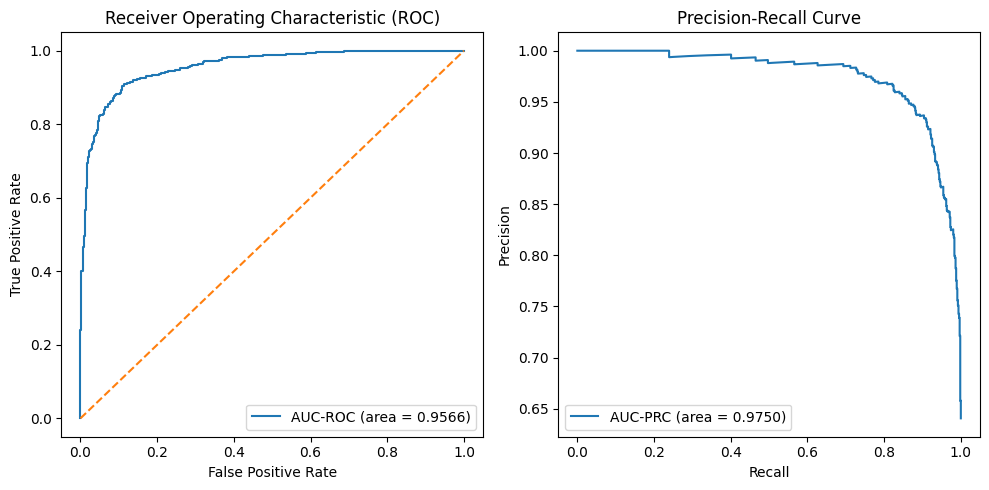

In [ ]:
evaluate_model(best_model,holdout_loader)

#### CNN

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, input_dim, out_channels, classification_layer_dim = 64 ):
        super().__init__()

        self.input_dim = input_dim
        self.out_channels = out_channels
        self.class_dim =  classification_layer_dim

        # Convolutional layers
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.out_channels * 4, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm1d(self.out_channels * 4),
            nn.PReLU(self.out_channels*4),
            nn.AvgPool1d(kernel_size=3, stride=2),
            nn.Dropout(0.2),
            nn.Conv1d(in_channels= self.out_channels * 4 , out_channels=self.out_channels *2 , kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(self.out_channels * 2),
            nn.PReLU(self.out_channels*2),
            nn.AvgPool1d(kernel_size=5, stride=2),
            nn.Dropout(0.2),
        )

        # Calculate the output size after convolutional layers
        self._conv_output_size = self._get_conv_output()

        self.fc = nn.Sequential(
            nn.Linear(self._conv_output_size, self.class_dim  ),
            nn.BatchNorm1d(self.class_dim),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(self.class_dim, self.class_dim //2 ),
            nn.BatchNorm1d(self.class_dim//2),
            nn.PReLU(self.class_dim//2),
            nn.Dropout(0.25),
            nn.Linear(self.class_dim//2 , 1)
        )

    def _get_conv_output(self):

        """
        Computes the size of the output of the convolutional layers
         to define the input size of the first linear layer.
        """
        # Create a dummy input tensor with batch size 1
        dummy_input = torch.zeros(1, 1, self.input_dim)
        output_feat = self.conv(dummy_input)
        output_size = output_feat.numel()
        print(output_size)
        return output_size

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x = x.unsqueeze(1)  # Add channel dimension: (batch_size, 1, input_dim)
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, conv_output_size)
        x = self.fc(x)
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader , val_loader , holdout_loader = create_loader(X_train=X_train, y_train = y_train,
                                                           X_val=X_val , y_val = y_val,
                                                           X_holdout = X_test , y_holdout=y_test,
                                                           batchsize = 16 )
learning_rate = 0.00005
out_channels = 18
classification_layer_dim = 128

conv_model = ConvNet(X_train.shape[1], out_channels, classification_layer_dim  ).to(device)
criterion = nn.BCEWithLogitsLoss( )
optimizer = torch.optim.Adam(conv_model.parameters(), lr=learning_rate, weight_decay = 1e-4)

13356


In [ ]:
best_model = train_model(conv_model, train_loader, val_loader, criterion, optimizer, num_epochs = 75  ,device=device , trigger_early_stop = True   )

Epoch [1/75], Train Loss: 0.4694, Train F1: 0.8439, Train AUC: 0.8559 | Val Loss: 0.3989, Val F1: 0.8788, Val AUC: 0.9086
Epoch [2/75], Train Loss: 0.3920, Train F1: 0.8737, Train AUC: 0.9002 | Val Loss: 0.3684, Val F1: 0.8720, Val AUC: 0.9193
Epoch [3/75], Train Loss: 0.3607, Train F1: 0.8822, Train AUC: 0.9165 | Val Loss: 0.3572, Val F1: 0.8841, Val AUC: 0.9276
Epoch [4/75], Train Loss: 0.3343, Train F1: 0.8947, Train AUC: 0.9293 | Val Loss: 0.3354, Val F1: 0.8837, Val AUC: 0.9298
Epoch [5/75], Train Loss: 0.3104, Train F1: 0.9022, Train AUC: 0.9393 | Val Loss: 0.3314, Val F1: 0.8872, Val AUC: 0.9316
Epoch [6/75], Train Loss: 0.2863, Train F1: 0.9102, Train AUC: 0.9491 | Val Loss: 0.3114, Val F1: 0.8991, Val AUC: 0.9387
Epoch [7/75], Train Loss: 0.2785, Train F1: 0.9103, Train AUC: 0.9522 | Val Loss: 0.3031, Val F1: 0.8986, Val AUC: 0.9410
Epoch [8/75], Train Loss: 0.2586, Train F1: 0.9209, Train AUC: 0.9592 | Val Loss: 0.2907, Val F1: 0.9102, Val AUC: 0.9457
Epoch [9/75], Train Loss

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.78      0.83       184
         1.0       0.89      0.94      0.91       328

    accuracy                           0.88       512
   macro avg       0.88      0.86      0.87       512
weighted avg       0.88      0.88      0.88       512

F1 Score: 0.9112


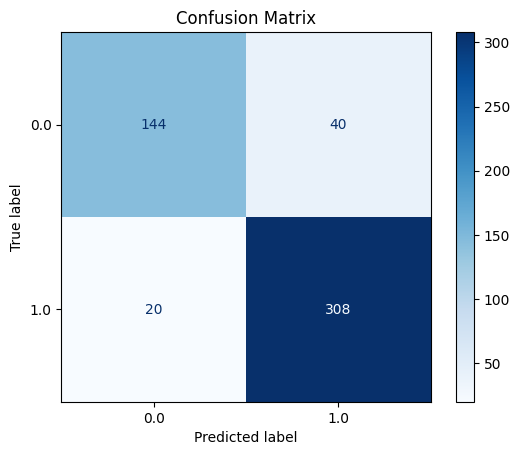

Sensitivity (Recall): 0.9390
Specificity: 0.7826
Precision: 0.8851
Recall: 0.9390
 
Matthews Correlation Coefficient (MCC): 0.7421
 


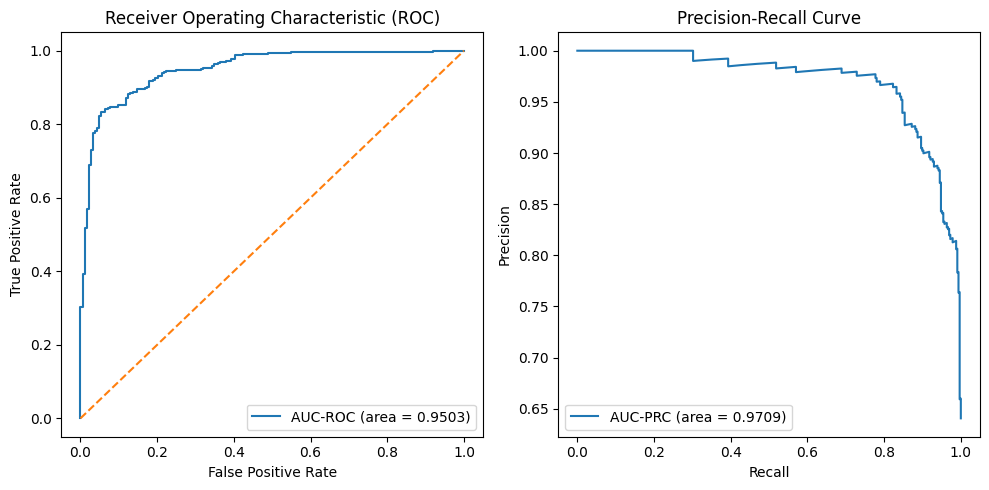

In [ ]:
evaluate_model(best_model,val_loader) # 58

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.81      0.85       368
         1.0       0.90      0.94      0.92       656

    accuracy                           0.89      1024
   macro avg       0.89      0.88      0.88      1024
weighted avg       0.89      0.89      0.89      1024

F1 Score: 0.9195


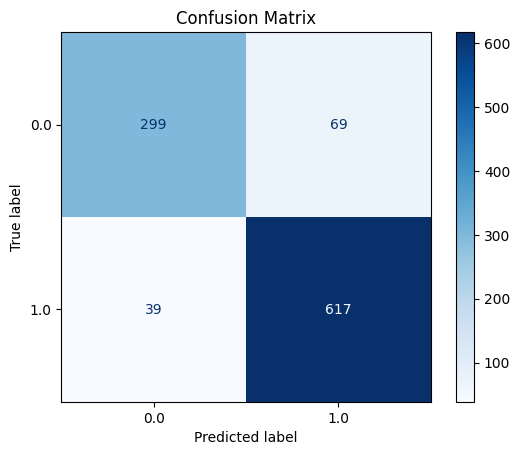

Sensitivity (Recall): 0.9405
Specificity: 0.8125
Precision: 0.8994
Recall: 0.9405
 
Matthews Correlation Coefficient (MCC): 0.7684
 


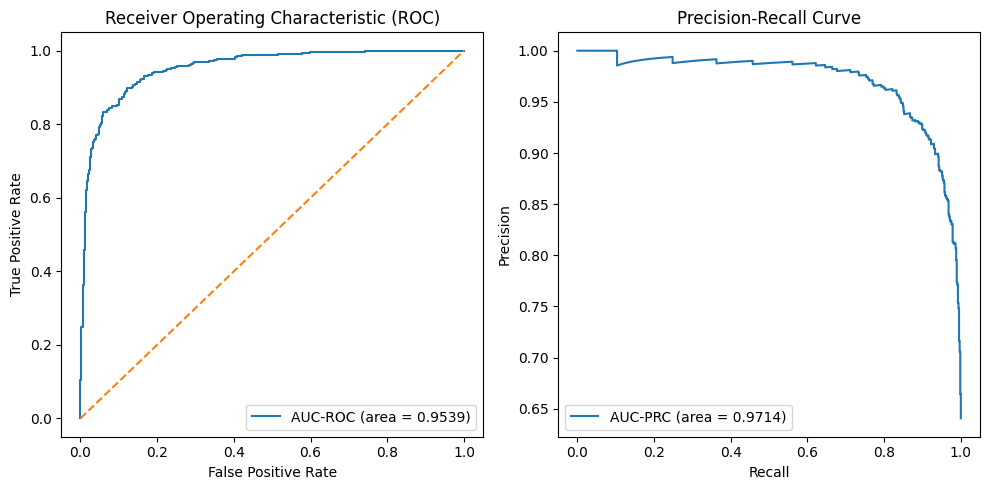

In [ ]:
evaluate_model(best_model,holdout_loader) # 103

In [ ]:
# torch.save(best_model, '/content/drive/My Drive/cnn_bbb_entire_model.pth')